# Testing TRIP analysis with Pyro

## Toy model network

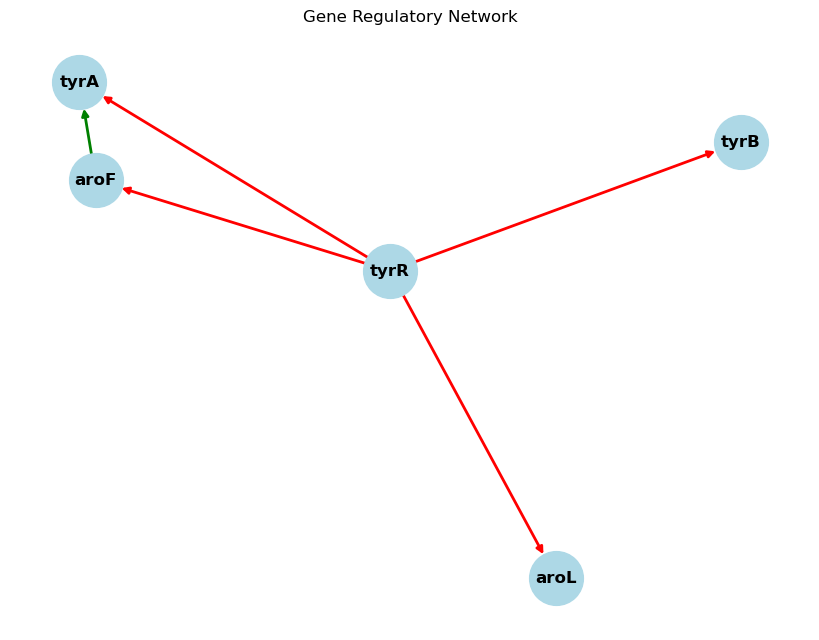

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes (genes)
genes = ["tyrR", "tyrA", "tyrB", "aroF", "aroL"]
G.add_nodes_from(genes)

# Add edges with regulatory information
# Format: (regulator, target, {'type': 'activation'/'repression'})
edges = [
    ("tyrR", "tyrA", {"type": "repression"}),
    ("tyrR", "tyrB", {"type": "repression"}),
    ("tyrR", "aroF", {"type": "repression"}),
    ("tyrR", "aroL", {"type": "repression"}),
    ("aroF", "tyrA", {"type": "activation"})
]
G.add_edges_from(edges)

# Visualize the network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
edge_colors = ["red" if G[u][v]["type"] == "repression" else "green" for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color="lightblue", 
        node_size=1500, font_size=12, font_weight="bold",
        edge_color=edge_colors, width=2, arrows=True)
plt.title("Gene Regulatory Network")
plt.show()

In [4]:
import tellurium as te
import matplotlib.pyplot as plt

# Define the model in Antimony with cell angle and reset on division
antimony_model = """
// Model of gene expression with DNA replication effects using cell angle
model GeneExpressionWithReplication()
  // Compartment
  compartment cell = 1.0;
  
  // All constants should be declared first
  // DNA replication timing parameters (in degrees, 0-360)
  const repl_angle_tyrR = 144.0;  // 0.4 * 360 = 144
  const repl_angle_tyrA = 151.2;  // 0.42 * 360 = 151.2
  const repl_angle_tyrB = 162.0;  // 0.45 * 360 = 162
  const repl_angle_aroF = 136.8;  // 0.38 * 360 = 136.8
  const repl_angle_aroL = 180.0;  // 0.5 * 360 = 180
  const cell_cycle_length = 30.0;  // Length of cell cycle in minutes
  const k_tx_tyrR = 0.5;
  const k_tx_tyrA = 0.4;
  const k_tx_tyrB = 0.6;
  const k_tx_aroF = 0.5;
  const k_tx_aroL = 0.45;
  const k_deg_mRNA = 0.2;
  const k_tl = 0.1;
  const k_deg_prot = 0.05;
  const n = 2.0;
  const K_tyrR = 5.0;
  
  // Species declarations
  species gene_tyrR in cell;
  species mRNA_tyrR in cell;
  species protein_tyrR in cell;
  species gene_tyrA in cell;
  species mRNA_tyrA in cell;
  species protein_tyrA in cell;
  species gene_tyrB in cell;
  species mRNA_tyrB in cell;
  species protein_tyrB in cell;
  species gene_aroF in cell;
  species mRNA_aroF in cell;
  species protein_aroF in cell;
  species gene_aroL in cell;
  species mRNA_aroL in cell;
  species protein_aroL in cell;
  species cell_angle in cell;  // Cell angle in degrees (0-360)
  
  // Initialize values
  gene_tyrR = 1.0; 
  gene_tyrA = 1.0; 
  gene_tyrB = 1.0; 
  gene_aroF = 1.0; 
  gene_aroL = 1.0;
  cell_angle = 0.0;  // Start at 0 degrees
  mRNA_tyrR = 0.0;
  mRNA_tyrA = 0.0;
  mRNA_tyrB = 0.0;
  mRNA_aroF = 0.0;
  mRNA_aroL = 0.0;
  protein_tyrR = 0.0;
  protein_tyrA = 0.0;
  protein_tyrB = 0.0;
  protein_aroF = 0.0;
  protein_aroL = 0.0;
  
  // mRNA synthesis (transcription) reactions
  J_tx_tyrR: -> mRNA_tyrR; k_tx_tyrR * gene_tyrR;
  
  // tyrA is repressed by tyrR and activated by aroF
  J_tx_tyrA: -> mRNA_tyrA; k_tx_tyrA * gene_tyrA * (1/(1+(protein_tyrR/K_tyrR)^n)) * (1 + 0.5*protein_aroF/(5.0 + protein_aroF));
  
  // tyrB is repressed by tyrR
  J_tx_tyrB: -> mRNA_tyrB; k_tx_tyrB * gene_tyrB * (1/(1+(protein_tyrR/K_tyrR)^n));
  
  // aroF is repressed by tyrR
  J_tx_aroF: -> mRNA_aroF; k_tx_aroF * gene_aroF * (1/(1+(protein_tyrR/K_tyrR)^n));
  
  // aroL is repressed by tyrR
  J_tx_aroL: -> mRNA_aroL; k_tx_aroL * gene_aroL * (1/(1+(protein_tyrR/K_tyrR)^n));
  
  // mRNA degradation
  J_deg_mRNA_tyrR: mRNA_tyrR ->; k_deg_mRNA * mRNA_tyrR;
  J_deg_mRNA_tyrA: mRNA_tyrA ->; k_deg_mRNA * mRNA_tyrA;
  J_deg_mRNA_tyrB: mRNA_tyrB ->; k_deg_mRNA * mRNA_tyrB;
  J_deg_mRNA_aroF: mRNA_aroF ->; k_deg_mRNA * mRNA_aroF;
  J_deg_mRNA_aroL: mRNA_aroL ->; k_deg_mRNA * mRNA_aroL;
  
  // Protein synthesis (translation) reactions
  J_tl_tyrR: mRNA_tyrR -> mRNA_tyrR + protein_tyrR; k_tl * mRNA_tyrR;
  J_tl_tyrA: mRNA_tyrA -> mRNA_tyrA + protein_tyrA; k_tl * mRNA_tyrA;
  J_tl_tyrB: mRNA_tyrB -> mRNA_tyrB + protein_tyrB; k_tl * mRNA_tyrB;
  J_tl_aroF: mRNA_aroF -> mRNA_aroF + protein_aroF; k_tl * mRNA_aroF;
  J_tl_aroL: mRNA_aroL -> mRNA_aroL + protein_aroL; k_tl * mRNA_aroL;
  
  // Protein degradation
  J_deg_prot_tyrR: protein_tyrR ->; k_deg_prot * protein_tyrR;
  J_deg_prot_tyrA: protein_tyrA ->; k_deg_prot * protein_tyrA;
  J_deg_prot_tyrB: protein_tyrB ->; k_deg_prot * protein_tyrB;
  J_deg_prot_aroF: protein_aroF ->; k_deg_prot * protein_aroF;
  J_deg_prot_aroL: protein_aroL ->; k_deg_prot * protein_aroL;
  
  // Cell cycle progression - angle increases from 0 to 360 degrees over the cell cycle
  J_cycle: -> cell_angle; 360.0/cell_cycle_length;  // Degrees per minut
  
  // Events for DNA replication based on cell angle
  replication_tyrR: at (cell_angle > repl_angle_tyrR): gene_tyrR = 2*gene_tyrR;
  replication_tyrA: at (cell_angle > repl_angle_tyrA): gene_tyrA = 2*gene_tyrA;
  replication_tyrB: at (cell_angle > repl_angle_tyrB): gene_tyrB = 2*gene_tyrB;
  replication_aroF: at (cell_angle > repl_angle_aroF): gene_aroF = 2*gene_aroF;
  replication_aroL: at (cell_angle > repl_angle_aroL): gene_aroL = 2*gene_aroL;
end
"""
# Create the model and simulate
cell_cycle_time = 30  # minutes
r = te.loada(antimony_model)
result = r.simulate(0, cell_cycle_time, 1000)  # Simulate for 30 minutes

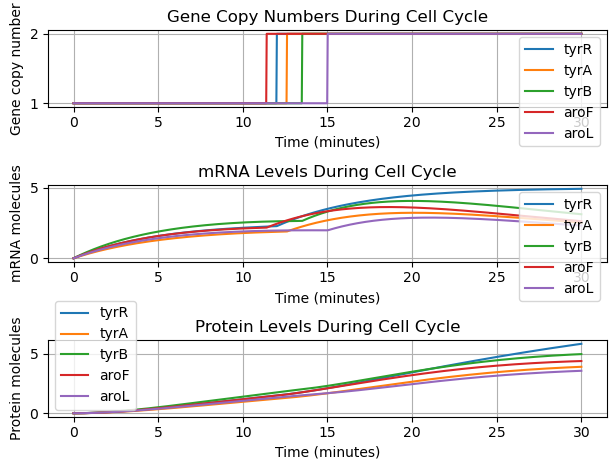

In [5]:


# Plot 1: Gene copy numbers
plt.subplot(3, 1, 1)
plt.plot(result['time'], result['[gene_tyrR]'], label='tyrR')
plt.plot(result['time'], result['[gene_tyrA]'], label='tyrA')
plt.plot(result['time'], result['[gene_tyrB]'], label='tyrB')
plt.plot(result['time'], result['[gene_aroF]'], label='aroF')
plt.plot(result['time'], result['[gene_aroL]'], label='aroL')
plt.xlabel('Time (minutes)')
plt.ylabel('Gene copy number')
plt.title('Gene Copy Numbers During Cell Cycle')
plt.grid(True)
plt.legend()

# Plot 2: mRNA levels
plt.subplot(3, 1, 2)
plt.plot(result['time'], result['[mRNA_tyrR]'], label='tyrR')
plt.plot(result['time'], result['[mRNA_tyrA]'], label='tyrA')
plt.plot(result['time'], result['[mRNA_tyrB]'], label='tyrB')
plt.plot(result['time'], result['[mRNA_aroF]'], label='aroF')
plt.plot(result['time'], result['[mRNA_aroL]'], label='aroL')
plt.xlabel('Time (minutes)')
plt.ylabel('mRNA molecules')
plt.title('mRNA Levels During Cell Cycle')
plt.grid(True)
plt.legend()

# Plot 3: Protein levels
plt.subplot(3, 1, 3)
plt.plot(result['time'], result['[protein_tyrR]'], label='tyrR')
plt.plot(result['time'], result['[protein_tyrA]'], label='tyrA')
plt.plot(result['time'], result['[protein_tyrB]'], label='tyrB')
plt.plot(result['time'], result['[protein_aroF]'], label='aroF')
plt.plot(result['time'], result['[protein_aroL]'], label='aroL')
plt.xlabel('Time (minutes)')
plt.ylabel('Protein molecules')
plt.title('Protein Levels During Cell Cycle')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import networkx as nx

def create_antimony_model(grn_graph, params=None, replication_timings=None):
    """
    Create an Antimony model string from a NetworkX graph representing a GRN.
    
    Parameters:
    -----------
    grn_graph : NetworkX DiGraph
        A directed graph where nodes are genes and edges represent regulatory interactions.
        Edges should have a 'type' attribute with value 'activation' or 'inhibition'.
    
    params : dict, optional
        Dictionary with parameter values. If not provided, defaults will be used.
    
    replication_timings : dict, optional
        Dictionary mapping gene names to their replication timing as a fraction of the cell cycle.
        If not provided, genes will be assigned evenly distributed values.
        
    Returns:
    --------
    str
        Antimony model string
    """
    # Default parameters if not provided
    default_params = {
        'cell_cycle_length': 30.0,  # Length of cell cycle in minutes
        'k_tx_default': 0.5,        # Default transcription rate
        'k_deg_mRNA': 0.2,          # mRNA degradation rate
        'k_tl': 0.1,                # Translation rate
        'k_deg_prot': 0.05,         # Protein degradation rate
        'hill_n': 2.0,              # Hill coefficient
        'K_default': 5.0,           # Default threshold for regulation
        'activation_strength': 0.5,  # Activation strength parameter
    }
    
    # Update with user provided parameters if any
    if params is not None:
        default_params.update(params)
    
    # Extract parameters
    p = default_params
    
    # Get gene names from the graph
    genes = list(grn_graph.nodes())
    
    # Default replication timings if not provided
    if replication_timings is None:
        replication_timings = {}
        for i, gene in enumerate(genes):
            # Distribute evenly between 0.1 and 0.9 of cell cycle
            replication_timings[gene] = 0.1 + (0.8 * i / max(1, len(genes) - 1))
    
    # Start building the model string
    model = """
    // Model of gene expression with DNA replication effects using cell angle
    model GeneExpressionWithReplication()
    // Compartment
    compartment cell = 1.0;
    
    // All constants should be declared first
    """
    
    # Add DNA replication timing parameters
    for gene in genes:
        repl_fraction = replication_timings.get(gene, 0.5)  # Default to middle if missing
        model += f"  const repl_angle_{gene} = {repl_fraction * 360:.1f};  // {repl_fraction:.2f} * 360\n"
    
    # Add other constants
    model += f"\n  const cell_cycle_length = {p['cell_cycle_length']};  // Length of cell cycle in minutes\n"
    
    # Add transcription rate constants for each gene
    for gene in genes:
        rate = p.get(f'k_tx_{gene}', p['k_tx_default'])
        model += f"  const k_tx_{gene} = {rate};\n"
    
    # Add other rate constants
    model += f"""  const k_deg_mRNA = {p['k_deg_mRNA']};
    const k_tl = {p['k_tl']};
    const k_deg_prot = {p['k_deg_prot']};
    const n = {p['hill_n']};\n"""
    
    # Add regulation thresholds for each gene that acts as a regulator
    regulators = set()
    for u, v, data in grn_graph.edges(data=True):
        regulators.add(u)
    
    for gene in regulators:
        threshold = p.get(f'K_{gene}', p['K_default'])
        model += f"  const K_{gene} = {threshold};\n"
    
    # Species declarations
    model += "\n  // Species declarations\n"
    for gene in genes:
        model += f"  species gene_{gene} in cell;\n"
        model += f"  species mRNA_{gene} in cell;\n"
        model += f"  species protein_{gene} in cell;\n"
    model += "  species cell_angle in cell;  // Cell angle in degrees (0-360)\n"
    
    # Initialize values
    model += "\n  // Initialize values\n"
    for gene in genes:
        model += f"  gene_{gene} = 1.0;\n"
    model += "  cell_angle = 0.0;  // Start at 0 degrees\n"
    for gene in genes:
        model += f"  mRNA_{gene} = 0.0;\n"
    for gene in genes:
        model += f"  protein_{gene} = 0.0;\n"
    
    # Create a dictionary to track regulators for each gene
    gene_regulators = {gene: {'activators': [], 'inhibitors': []} for gene in genes}
    
    # Populate the regulators dictionary
    for u, v, data in grn_graph.edges(data=True):
        if 'type' not in data:
            raise ValueError(f"Edge from {u} to {v} missing 'type' attribute")
            
        edge_type = data['type']
        if edge_type == 'activation':
            gene_regulators[v]['activators'].append(u)
        elif edge_type == 'inhibition':
            gene_regulators[v]['inhibitors'].append(u)
        else:
            gene_regulators[v]['activators'].append(u)  # default to activation if type is unknown
    
    # Transcription reactions
    model += "\n  // mRNA synthesis (transcription) reactions\n"
    for gene in genes:
        # Basic transcription rate
        reaction = f"  J_tx_{gene}: -> mRNA_{gene}; k_tx_{gene} * gene_{gene}"
        
        # Add inhibition terms
        for inhibitor in gene_regulators[gene]['inhibitors']:
            reaction += f" * (1/(1+(protein_{inhibitor}/K_{inhibitor})^n))"
        
        # Add activation terms
        for activator in gene_regulators[gene]['activators']:
            reaction += f" * (1 + {p['activation_strength']}*protein_{activator}/({p['K_default']} + protein_{activator}))"
        
        reaction += ";\n"
        model += reaction
    
    # Add rest of the reactions
    model += "\n  // mRNA degradation\n"
    for gene in genes:
        model += f"  J_deg_mRNA_{gene}: mRNA_{gene} ->; k_deg_mRNA * mRNA_{gene};\n"
    
    model += "\n  // Protein synthesis (translation) reactions\n"
    for gene in genes:
        model += f"  J_tl_{gene}: mRNA_{gene} -> mRNA_{gene} + protein_{gene}; k_tl * mRNA_{gene};\n"
    
    model += "\n  // Protein degradation\n"
    for gene in genes:
        model += f"  J_deg_prot_{gene}: protein_{gene} ->; k_deg_prot * protein_{gene};\n"
    
    model += """
    // Cell cycle progression - angle increases from 0 to 360 degrees over the cell cycle
    J_cycle: -> cell_angle; 360.0/cell_cycle_length;
    
    // Events for DNA replication based on cell angle
    """
    
    # DNA replication events
    for gene in genes:
        model += f"  replication_{gene}: at (cell_angle > repl_angle_{gene}): gene_{gene} = 2*gene_{gene};\n"
    
    model += "end\n"
    
    return model

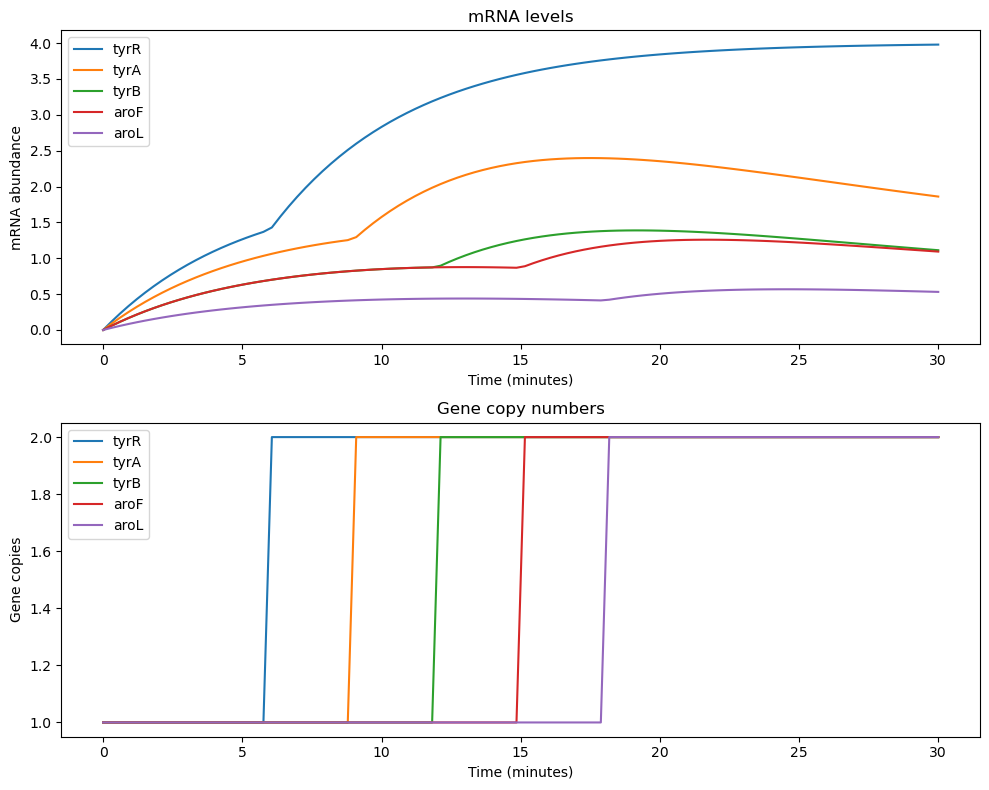

In [7]:
# Example of creating a GRN and generating its Antimony model
import networkx as nx
import tellurium as te
import matplotlib.pyplot as plt

# Create a NetworkX graph for your gene regulatory network
G = nx.DiGraph()

# Add nodes (genes)
genes = ['tyrR', 'tyrA', 'tyrB', 'aroF', 'aroL']
G.add_nodes_from(genes)

# Add edges with regulatory information
edges = [
    ('tyrR', 'tyrA', {'type': 'inhibition'}),
    ('tyrR', 'tyrB', {'type': 'inhibition'}),
    ('tyrR', 'aroF', {'type': 'inhibition'}),
    ('tyrR', 'aroL', {'type': 'inhibition'}),
    ('aroF', 'tyrA', {'type': 'activation'})
]
G.add_edges_from(edges)

# Define replication timings (optional)
replication_timings = {
    'tyrR': 0.2,
    'tyrA': 0.3, 
    'tyrB': 0.4,
    'aroF': 0.5,
    'aroL': 0.6
}

# Define custom parameters (optional)
params = {
    'k_tx_tyrR': 0.4,
    'k_tx_tyrA': 0.3,
    'k_tx_tyrB': 0.2,
    'k_tx_aroF': 0.2,
    'k_tx_aroL': 0.1,
    'K_tyrR': 5.0
}

# Generate the Antimony model
antimony_model = create_antimony_model(G, params, replication_timings)

# Simulate the model
r = te.loada(antimony_model)
result = r.simulate(0, 30, 100)  # 2 cell cycles

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for gene in genes:
    plt.plot(result['time'], result[f'[mRNA_{gene}]'], label=f'{gene}')
plt.xlabel('Time (minutes)')
plt.ylabel('mRNA abundance')
plt.title('mRNA levels')
plt.legend()

plt.subplot(2, 1, 2)
for gene in genes:
    plt.plot(result['time'], result[f'[gene_{gene}]'], label=f'{gene}')
plt.xlabel('Time (minutes)')
plt.ylabel('Gene copies')
plt.title('Gene copy numbers')
plt.legend()

plt.tight_layout()
plt.show()

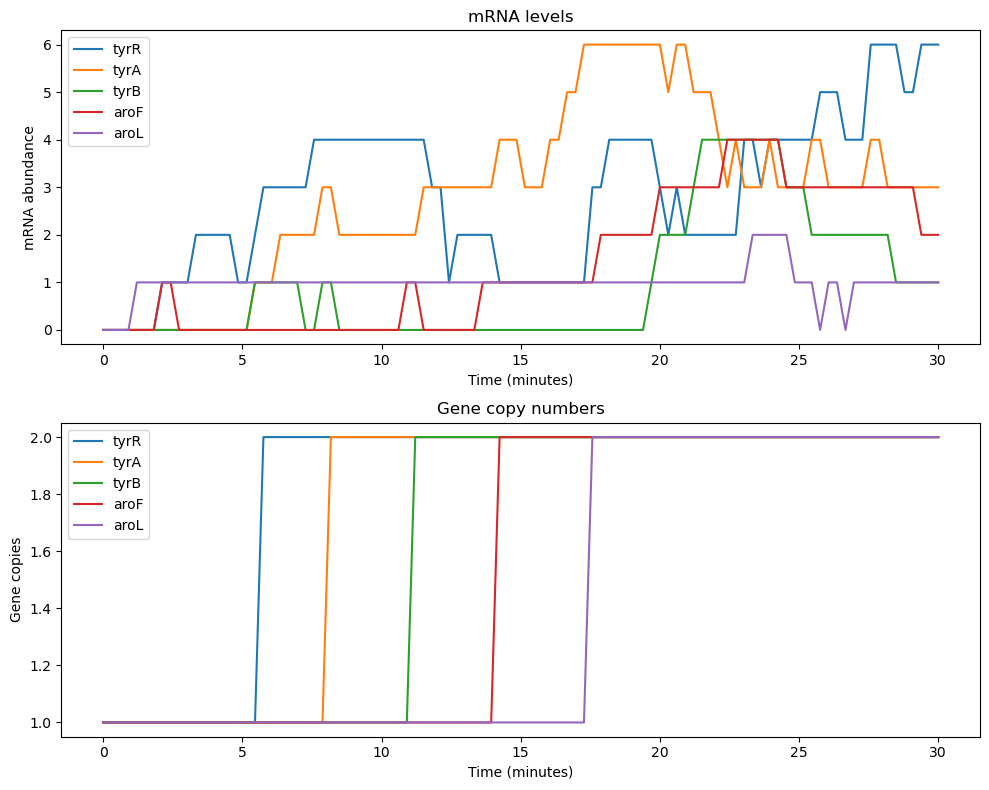

In [8]:
r = te.loada(antimony_model)
r.integrator = 'gillespie'
r.integrator.seed = 123  # For reproducibility
result = r.simulate(0, 30, 100)  # 2 cell cycles

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for gene in genes:
    plt.plot(result['time'], result[f'[mRNA_{gene}]'], label=f'{gene}')
plt.xlabel('Time (minutes)')
plt.ylabel('mRNA abundance')
plt.title('mRNA levels')
plt.legend()

plt.subplot(2, 1, 2)
for gene in genes:
    plt.plot(result['time'], result[f'[gene_{gene}]'], label=f'{gene}')
plt.xlabel('Time (minutes)')
plt.ylabel('Gene copies')
plt.title('Gene copy numbers')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tellurium as te
import numpy as np
import time 
import pandas as pd

def run_single_gillespie(rr_model, end_time, num_points, seed=None):
    """Run a single Gillespie simulation with given parameters"""
    rr_model.integrator = 'gillespie'
    if seed is not None:
        rr_model.integrator.seed = seed
    result = rr_model.simulate(0, end_time, num_points)
    rr_model.resetToOrigin()
    return result

def run_bulk_gillespie_serial(rr_model, end_time, num_points, num_simulations, seed=None):
    """Run multiple Gillespie simulations in series"""
    results = []
    for i in range(num_simulations):
        if seed is not None:
            np.random.seed(seed + i)
        result = run_single_gillespie(rr_model, end_time, num_points)
        results.append(result)
    return results


def save_results_to_dataframe(simulations, species_list):
    """Save Gillespie simulation results to a pandas DataFrame"""
    df_list = []
    
    for idx, sim in enumerate(simulations):
        df = pd.DataFrame(sim, columns=['Time'] + species_list)
        df['Simulation'] = idx
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)



num_simulations = 1000

# Measure time for single Gillespie simulation
rr_model = te.loada(antimony_model)
start_time = time.time()
result = run_single_gillespie(rr_model, 36, 72, seed=123)
single_time = time.time() - start_time
print(f"Time for single Gillespie simulation: {single_time:.4f} seconds")

# Measure time for bulk Gillespie simulations (serial)
start_time = time.time()
bulk_results = run_bulk_gillespie_serial(rr_model, 36, 72, num_simulations, seed=None)
serial_time = time.time() - start_time
print(f"Time for bulk ({num_simulations}) Gillespie simulations (serial): {serial_time:.4f} seconds")


df = save_results_to_dataframe(bulk_results,rr_model.getFloatingSpeciesIds())
df.head()

Time for single Gillespie simulation: 0.0006 seconds
Time for bulk (1000) Gillespie simulations (serial): 0.3962 seconds


,Time,gene_tyrR,mRNA_tyrR,protein_tyrR,gene_tyrA,mRNA_tyrA,protein_tyrA,gene_tyrB,mRNA_tyrB,protein_tyrB,gene_aroF,mRNA_aroF,protein_aroF,gene_aroL,mRNA_aroL,protein_aroL,cell_angle,Simulation
0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,0.507042,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5.0,0
2,1.014085,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,11.0,0
3,1.521127,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,20.0,0
4,2.028169,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,25.0,0


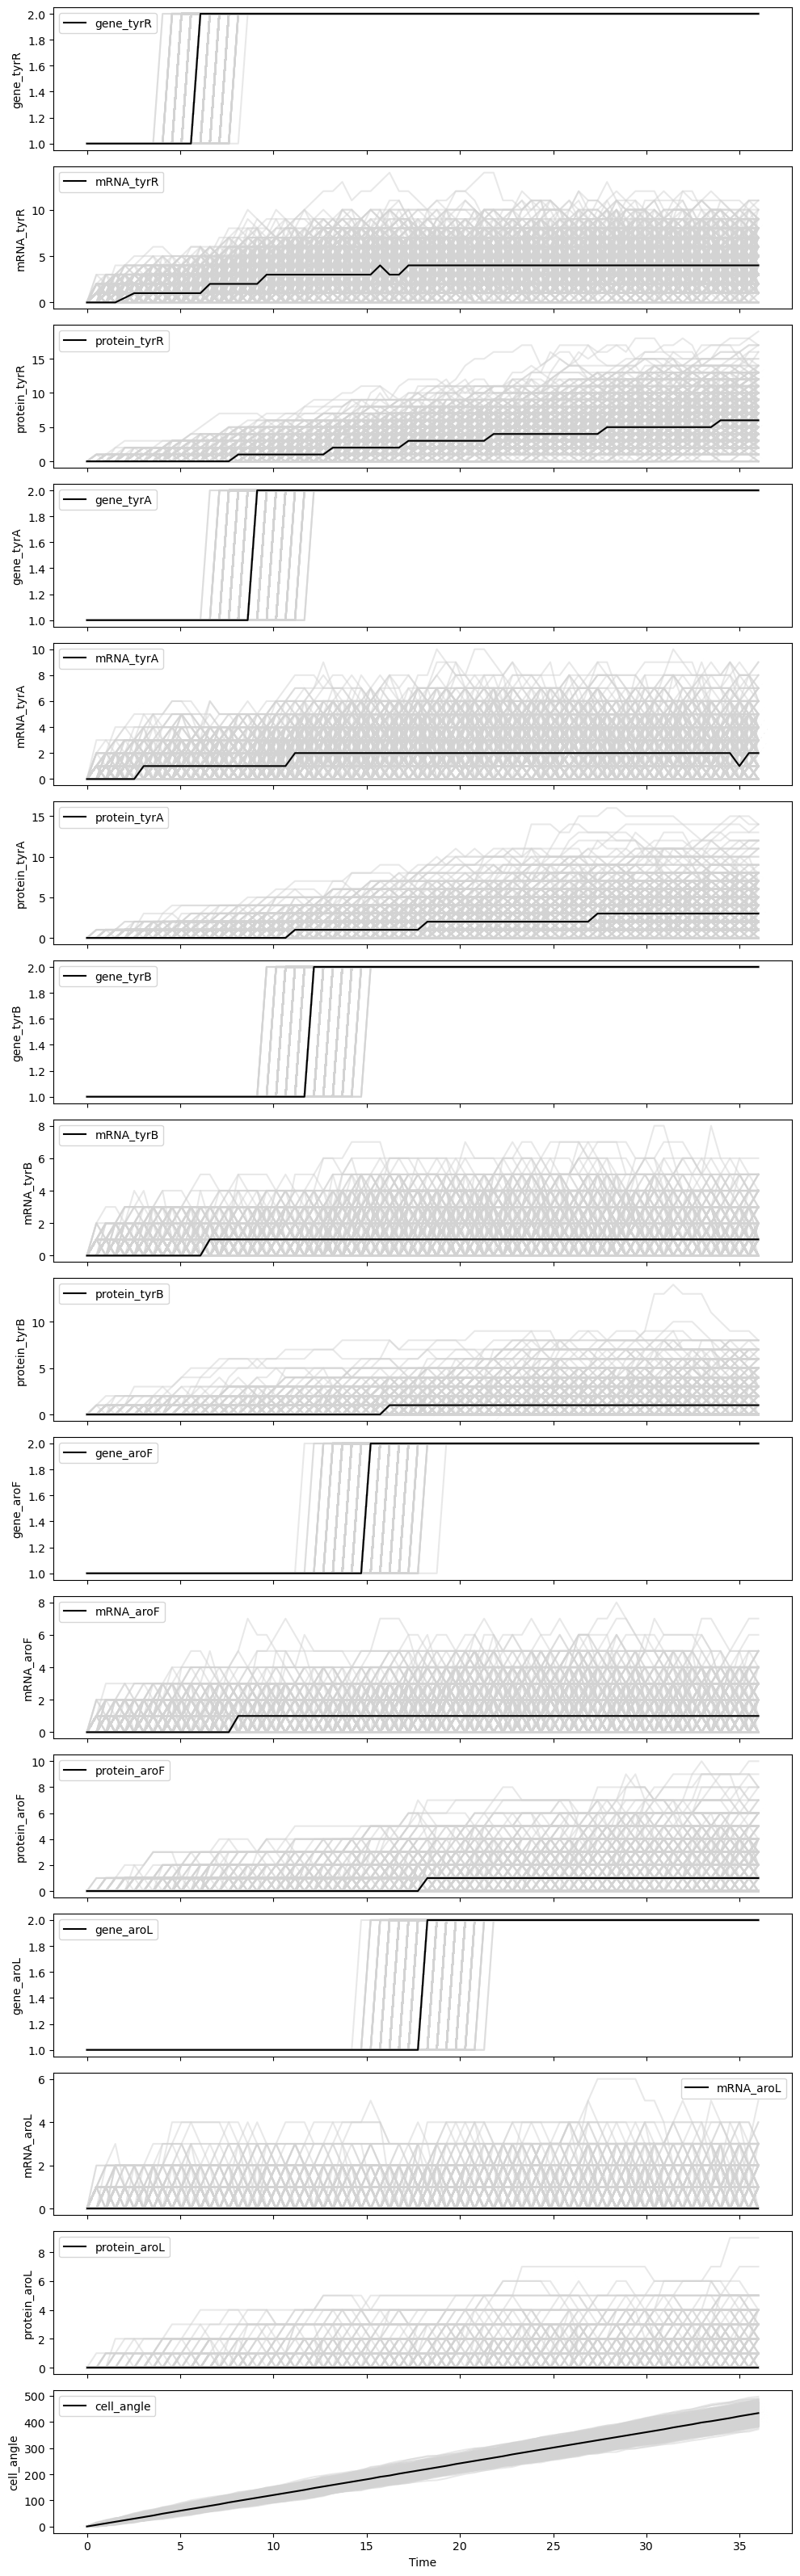

In [10]:
def plot_results(df):
    """Plot each column in df as its own subplot, based on the simulation number"""
    columns = df.columns.drop(['Time', 'Simulation'])
    num_subplots = len(columns)
    
    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 2*num_subplots), sharex=True)
    
    if num_subplots == 1:
        axes = [axes]
    
    for idx, col in enumerate(columns):
        for sim in df['Simulation'].unique():
            sim_data = df[df['Simulation'] == sim]
            axes[idx].plot(sim_data['Time'], sim_data[col], color='lightgrey', alpha=0.5)
        
        median_data = df.groupby('Time')[col].median()
        axes[idx].plot(median_data.index, median_data.values, color='black', label=f'{col}')
        
        axes[idx].set_ylabel(f'{col}')
        axes[idx].legend()
    
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

plot_results(df)

       Time  Simulation  tyrR  tyrA  tyrB  aroF  aroL
0  0.000000           0   0.0   0.0   0.0   0.0   0.0
1  0.507042           0   0.0   0.0   0.0   1.0   1.0
2  1.014085           0   0.0   0.0   0.0   1.0   1.0
3  1.521127           0   0.0   0.0   0.0   1.0   1.0
4  2.028169           0   0.0   0.0   1.0   1.0   1.0


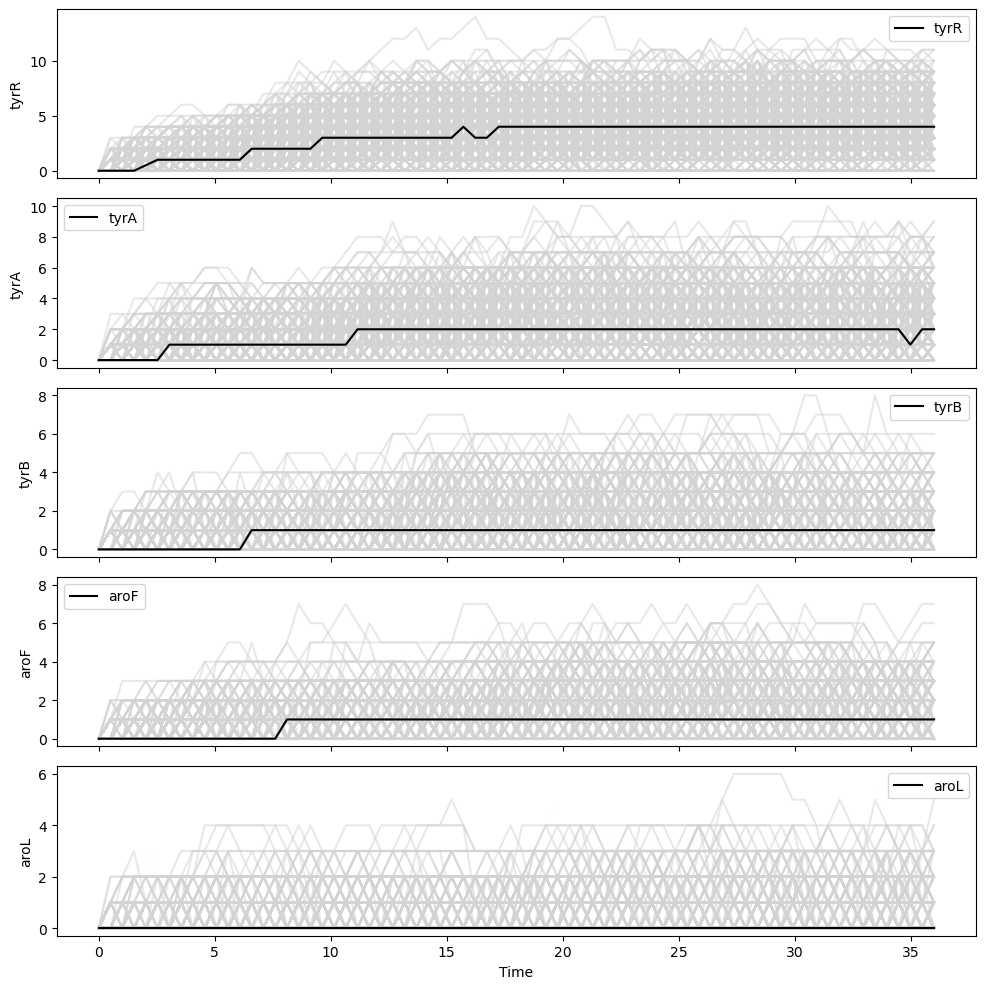

In [11]:
# Filter columns that start with 'mRNA_'
mRNA_columns = [col for col in df.columns if col.startswith('mRNA_')]

# Create a new DataFrame with only the filtered columns
mRNA_df = df[['Time', 'Simulation'] + mRNA_columns]

# Rename the columns to remove the 'mRNA_' prefix
mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]

# Display the new DataFrame
print(mRNA_df.head())

plot_results(mRNA_df)

In [12]:
# Aggregate results by Time, computing the sum for each gene
aggregated_df = mRNA_df.groupby('Time').sum().reset_index()

# Drop the 'Simulation' column
aggregated_df = aggregated_df.drop(columns=['Simulation'])

# Display the aggregated DataFrame
display(aggregated_df.head())


,Time,tyrR,tyrA,tyrB,aroF,aroL
0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.507042,217.0,138.0,92.0,88.0,61.0
2,1.014085,399.0,269.0,184.0,165.0,92.0
3,1.521127,551.0,400.0,264.0,222.0,128.0
4,2.028169,687.0,515.0,329.0,285.0,165.0


In [13]:
from scipy.stats import zscore

# Compute z-scores for each gene column
zscore_df = aggregated_df.copy()
zscore_df.iloc[:, 1:] = zscore(zscore_df.iloc[:, 1:], axis=0)

# Display the z-score DataFrame
display(zscore_df.head())

,Time,tyrR,tyrA,tyrB,aroF,aroL
0,0.000000,-2.589338,-2.849202,-2.913819,-2.830357,-3.060134
1,0.507042,-2.409749,-2.620149,-2.644423,-2.564881,-2.648063
2,1.014085,-2.259127,-2.402714,-2.375027,-2.332590,-2.438650
3,1.521127,-2.133333,-2.185278,-2.140770,-2.160634,-2.195460
4,2.028169,-2.020780,-1.994400,-1.950436,-1.970578,-1.945515


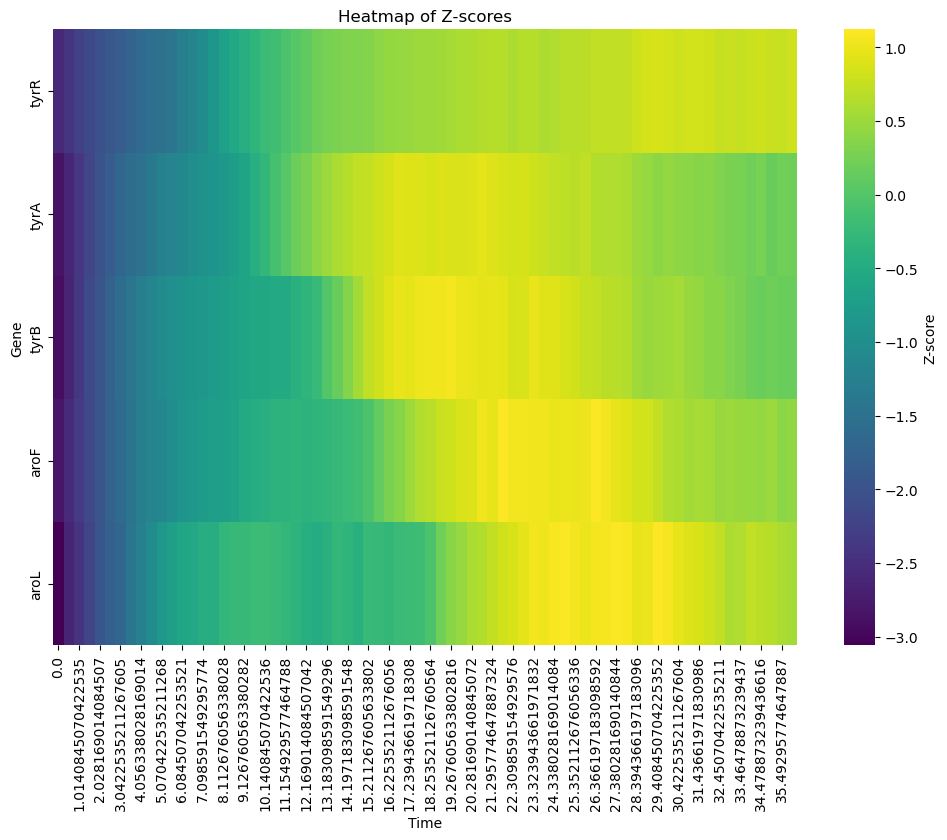

In [14]:
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap_data = zscore_df.set_index('Time').T  # Transpose to have genes as rows and Time as columns
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Z-score'})
plt.xlabel('Time')
plt.ylabel('Gene')
plt.title('Heatmap of Z-scores')
plt.show()


# tyrR subnetwork

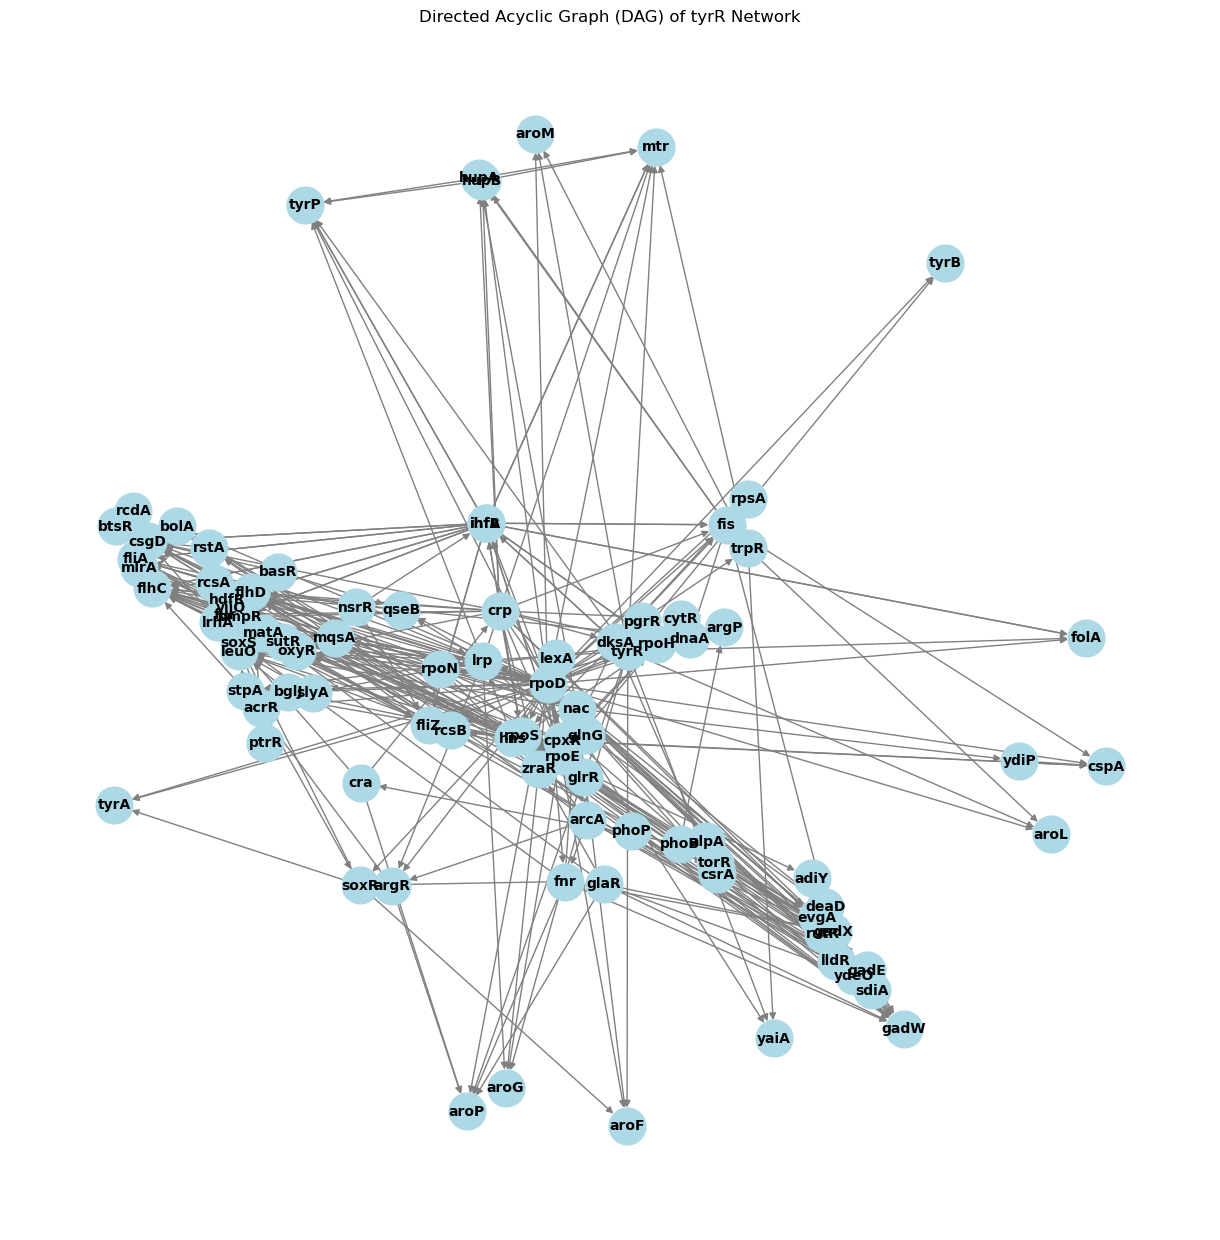

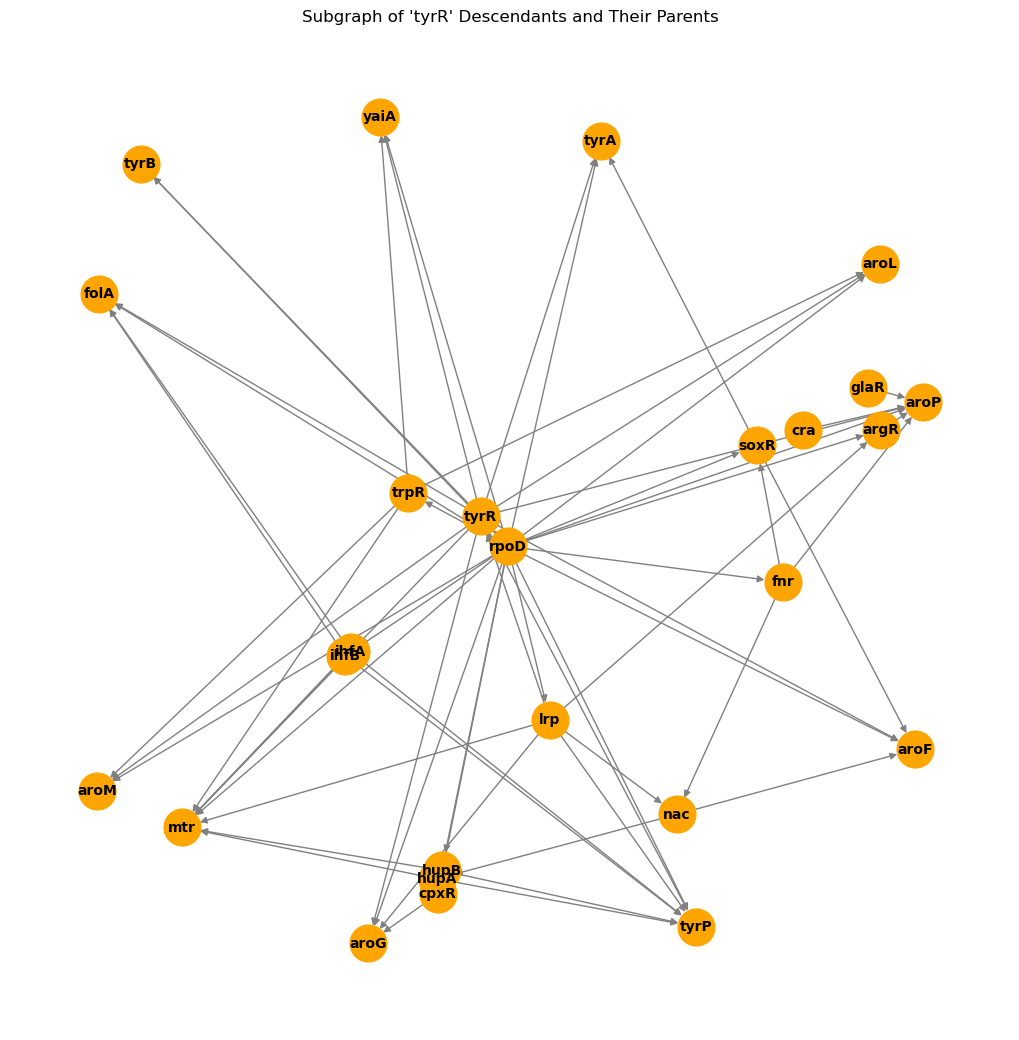

Original Graph: 92 nodes, 344 edges
Subgraph: 26 nodes, 63 edges


In [15]:
graphml_file = "../TRIPS_data/TyrR_all_ancestors_graph_3_bins.gml"
DAG = nx.read_gml(graphml_file)
# display the graph 
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(DAG, seed=40)  # positions for all nodes
nx.draw(DAG, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Directed Acyclic Graph (DAG) of tyrR Network")
plt.show()

# Get the descendants of 'tyrR' and their parents
descendants = nx.descendants(DAG, 'tyrR')
nodes_to_include = set(descendants)
for node in descendants:
    nodes_to_include.update(DAG.predecessors(node))

# Include 'tyrR' itself
nodes_to_include.add('tyrR')

# Create the subgraph
descendants_with_parents_subgraph = DAG.subgraph(nodes_to_include)

# Plot the subgraph
plt.figure(figsize=(10, 10))
pos_descendants = nx.spring_layout(descendants_with_parents_subgraph, seed=42)
nx.draw(descendants_with_parents_subgraph, pos_descendants, with_labels=True, node_size=700, node_color='orange', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Subgraph of 'tyrR' Descendants and Their Parents")
plt.show()

# Compare the number of nodes and edges in the original graph and the subgraph
original_nodes = DAG.number_of_nodes()
original_edges = DAG.number_of_edges()
subgraph_nodes = descendants_with_parents_subgraph.number_of_nodes()
subgraph_edges = descendants_with_parents_subgraph.number_of_edges()

print(f"Original Graph: {original_nodes} nodes, {original_edges} edges")
print(f"Subgraph: {subgraph_nodes} nodes, {subgraph_edges} edges")

In [16]:
# go through graph edges, rename 'polarity' to 'type', and change '+' to 'activation' and '-' to 'inhibition' and '+/-' to None
for u, v, data in descendants_with_parents_subgraph.edges(data=True):
    if 'polarity' in data:
        polarity = data['polarity']
        if polarity == '+':
            data['type'] = 'activation'
        elif polarity == '-':
            data['type'] = 'inhibition'
        elif polarity == '+/-':
            data['type'] = None
        del data['polarity']


tyrR_antimony_model = create_antimony_model(descendants_with_parents_subgraph)
tyrR_rr_model = te.loada(tyrR_antimony_model)



In [ ]:
num_simulations = 1000

start_time = time.time()
result = run_single_gillespie(tyrR_rr_model, 36, 36, seed=123)
single_time = time.time() - start_time
print(f"Time for single Gillespie simulation: {single_time:.4f} seconds")

# Measure time for bulk Gillespie simulations (serial)
start_time = time.time()
bulk_results = run_bulk_gillespie_serial(tyrR_rr_model, 36, 36, num_simulations, seed=None)
serial_time = time.time() - start_time
print(f"Time for bulk ({num_simulations}) Gillespie simulations (serial): {serial_time:.4f} seconds")

start_time = time.time()
tyrR_df = save_results_to_dataframe(bulk_results,tyrR_rr_model.getFloatingSpeciesIds())
serial_time = time.time() - start_time
print(f"Time for save df: {serial_time:.4f} seconds")
tyrR_df.head()

Time for single Gillespie simulation: 0.0050 seconds
Time for bulk (1000) Gillespie simulations (serial): 2.9975 seconds
Time for save df: 0.0905 seconds


,Time,gene_glaR,mRNA_glaR,protein_glaR,gene_aroP,mRNA_aroP,protein_aroP,gene_nac,mRNA_nac,protein_nac,...,mRNA_hupA,protein_hupA,gene_aroG,mRNA_aroG,protein_aroG,gene_aroL,mRNA_aroL,protein_aroL,cell_angle,Simulation
0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,1.028571,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,14.0,0
2,2.057143,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,26.0,0
3,3.085714,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,36.0,0
4,4.114286,2.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,52.0,0


In [18]:
#plot_results(tyrR_df)

In [19]:
def run_parameter_sweep(grn_graph, param_sets, num_simulations, end_time=36, num_points=36, seed=None):
    """Run parameter sweep over multiple parameter sets."""
    results = []
    for params in param_sets:
        antimony_str = create_antimony_model(grn_graph, params)
        rr_model = te.loada(antimony_str)
        bulk_results = run_bulk_gillespie_serial(rr_model, end_time, num_points, num_simulations, seed)
        results.append((params, bulk_results))
    return results

def get_model_parameters(rr_model):
    """Retrieve the list of parameter names and their current values from the model."""
    parameter_ids = rr_model.getGlobalParameterIds()
    parameters = {param: rr_model.getValue(param) for param in parameter_ids}
    return parameters

parameters = get_model_parameters(tyrR_rr_model)
display(parameters)



{'repl_angle_glaR': 36.0,
 'repl_angle_aroP': 47.5,
 'repl_angle_nac': 59.0,
 'repl_angle_soxR': 70.6,
 'repl_angle_tyrA': 82.1,
 'repl_angle_fnr': 93.6,
 'repl_angle_aroF': 105.1,
 'repl_angle_cra': 116.6,
 'repl_angle_hupB': 128.2,
 'repl_angle_mtr': 139.7,
 'repl_angle_tyrP': 151.2,
 'repl_angle_lrp': 162.7,
 'repl_angle_yaiA': 174.2,
 'repl_angle_rpoD': 185.8,
 'repl_angle_trpR': 197.3,
 'repl_angle_argR': 208.8,
 'repl_angle_tyrB': 220.3,
 'repl_angle_ihfA': 231.8,
 'repl_angle_aroM': 243.4,
 'repl_angle_cpxR': 254.9,
 'repl_angle_ihfB': 266.4,
 'repl_angle_tyrR': 277.9,
 'repl_angle_folA': 289.4,
 'repl_angle_hupA': 301.0,
 'repl_angle_aroG': 312.5,
 'repl_angle_aroL': 324.0,
 'cell_cycle_length': 30.0,
 'k_tx_glaR': 0.5,
 'k_tx_aroP': 0.5,
 'k_tx_nac': 0.5,
 'k_tx_soxR': 0.5,
 'k_tx_tyrA': 0.5,
 'k_tx_fnr': 0.5,
 'k_tx_aroF': 0.5,
 'k_tx_cra': 0.5,
 'k_tx_hupB': 0.5,
 'k_tx_mtr': 0.5,
 'k_tx_tyrP': 0.5,
 'k_tx_lrp': 0.5,
 'k_tx_yaiA': 0.5,
 'k_tx_rpoD': 0.5,
 'k_tx_trpR': 0.5,
 

In [20]:
# Define parameter ranges for different types
param_ranges = {
    'repl_angle': (0, 360),
    'cell_cycle_length': (10, 60),
    'k_tx': (0.1, 2.0),
    'k_deg_mRNA': (0.05, 1.0),
    'k_tl': (0.01, 0.5),
    'k_deg_prot': (0.01, 0.2),
    'n': (1, 4),
    'K': (1.0, 10.0)
}

# Create the parameters with bounds data structure
parameters_with_bounds = {}

for key, value in parameters.items():
    for param_type, bounds in param_ranges.items():
        if key.startswith(param_type) or key == param_type:
            parameters_with_bounds[key] = (value, bounds[0], bounds[1])
            break

# Display the resultant structure
for k, v in parameters_with_bounds.items():
    print(f"{k}: {v}")

repl_angle_glaR: (36.0, 0, 360)
repl_angle_aroP: (47.5, 0, 360)
repl_angle_nac: (59.0, 0, 360)
repl_angle_soxR: (70.6, 0, 360)
repl_angle_tyrA: (82.1, 0, 360)
repl_angle_fnr: (93.6, 0, 360)
repl_angle_aroF: (105.1, 0, 360)
repl_angle_cra: (116.6, 0, 360)
repl_angle_hupB: (128.2, 0, 360)
repl_angle_mtr: (139.7, 0, 360)
repl_angle_tyrP: (151.2, 0, 360)
repl_angle_lrp: (162.7, 0, 360)
repl_angle_yaiA: (174.2, 0, 360)
repl_angle_rpoD: (185.8, 0, 360)
repl_angle_trpR: (197.3, 0, 360)
repl_angle_argR: (208.8, 0, 360)
repl_angle_tyrB: (220.3, 0, 360)
repl_angle_ihfA: (231.8, 0, 360)
repl_angle_aroM: (243.4, 0, 360)
repl_angle_cpxR: (254.9, 0, 360)
repl_angle_ihfB: (266.4, 0, 360)
repl_angle_tyrR: (277.9, 0, 360)
repl_angle_folA: (289.4, 0, 360)
repl_angle_hupA: (301.0, 0, 360)
repl_angle_aroG: (312.5, 0, 360)
repl_angle_aroL: (324.0, 0, 360)
cell_cycle_length: (30.0, 10, 60)
k_tx_glaR: (0.5, 0.1, 2.0)
k_tx_aroP: (0.5, 0.1, 2.0)
k_tx_nac: (0.5, 0.1, 2.0)
k_tx_soxR: (0.5, 0.1, 2.0)
k_tx_tyrA: (

In [32]:
import tellurium as te
import numpy as np
import pandas as pd


def generate_random_parameter_sets(parameter_bounds, n_samples=1):
    """Generate random parameters within the specified bounds."""
    random_parameter_sets = []
    for sample in range(n_samples):
        random_parameters = {}
        for param, (nominal, low, high) in parameter_bounds.items():
            random_value = np.random.uniform(low, high)
            random_parameters[param] = random_value
        random_parameter_sets.append(random_parameters)
    return random_parameter_sets


def update_model_parameters(rr_model, params):
    """Update the parameters of the model with given values."""
    for param, value in params.items():
        rr_model.setGlobalParameterByName(param, value)
           

def run_simulations_with_params(grn_graph, params, end_time, num_points, num_simulations, seed=None):
    """Update the model with given parameters and run bulk Gillespie simulations."""
    # Create the Antimony model string with the provided parameters
    antimony_str = create_antimony_model(grn_graph, params)
    rr_model = te.loada(antimony_str)
    
    # Update the model parameters with the given parameter set
    update_model_parameters(rr_model, params)
    
    # Run bulk Gillespie simulations
    results = run_bulk_gillespie_serial(rr_model, end_time, num_points, num_simulations, seed)
    return results

  
random_parameter_sets = generate_random_parameter_sets(parameters_with_bounds, n_samples=3)

# Display the random parameters
for i, random_parameters in enumerate(random_parameter_sets):
    print(f"Random Parameter Set {i+1}:")
    for k, v in random_parameters.items():
        print(f"{k}: {v}")
    print("\n")


# Run simulations with parameters
#sim_data = run_simulations_with_params(descendants_with_parents_subgraph, parameters, end_time=36, num_points=36, num_simulations=1000)


# Measure time for bulk Gillespie simulations (serial)
start_time = time.time()
bulk_results = run_simulations_with_params(descendants_with_parents_subgraph, parameters, end_time=36, num_points=36, num_simulations=1000)
serial_time = time.time() - start_time
print(f"Time for bulk ({num_simulations}) Gillespie simulations (serial): {serial_time:.4f} seconds")



Random Parameter Set 1:
repl_angle_glaR: 274.83517816955634
repl_angle_aroP: 277.14753890681874
repl_angle_nac: 46.5759229034149
repl_angle_soxR: 352.7125328168431
repl_angle_tyrA: 133.7378900125574
repl_angle_fnr: 227.94210022144782
repl_angle_aroF: 31.272555561935008
repl_angle_cra: 43.06426993623927
repl_angle_hupB: 327.8441764004987
repl_angle_mtr: 199.14029772118292
repl_angle_tyrP: 354.07421396263845
repl_angle_lrp: 23.15402875232213
repl_angle_yaiA: 130.0898679434506
repl_angle_rpoD: 307.2170958478761
repl_angle_trpR: 330.895586312343
repl_angle_argR: 251.8171505392391
repl_angle_tyrB: 181.39538971782625
repl_angle_ihfA: 238.83294789931912
repl_angle_aroM: 223.37121489094304
repl_angle_cpxR: 41.904401876633074
repl_angle_ihfB: 152.1788656395613
repl_angle_tyrR: 129.01326657668167
repl_angle_folA: 122.24166044966962
repl_angle_hupA: 34.53080178059687
repl_angle_aroG: 158.2485191077592
repl_angle_aroL: 157.9679963138833
cell_cycle_length: 59.86954404054435
k_tx_glaR: 1.19339877219

## Train surrogate model

In [48]:
import time


def generate_training_data(grn_graph, param_sets, end_time, num_points, num_simulations):
    X = []
    Y = []

    temp_antimony_str = create_antimony_model(grn_graph, param_sets[0])
    temp_rr_model = te.loada(temp_antimony_str)
    species_list = temp_rr_model.getFloatingSpeciesIds()
    
    for params in param_sets:
        sim_data = run_simulations_with_params(grn_graph, params, end_time, num_points, num_simulations)
        sim_df = save_results_to_dataframe(sim_data, species_list)
    
        # Filter columns that start with 'mRNA_'
        mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]

        # Create a new DataFrame with only the filtered columns
        mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]

        # Rename the columns to remove the 'mRNA_' prefix
        mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
        
        # Aggregate results by Time, computing the sum for each gene
        aggregated_df = mRNA_df.groupby('Time').sum().reset_index()

        # Drop the 'Simulation' column
        aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])

        y_values = aggregated_df.values

        X.append(list(params.values()))
        Y.append(y_values)
    
    return np.array(X), np.array(Y)

# Example parameter sets
num_samples = 1000
param_sets = generate_random_parameter_sets(parameters_with_bounds, num_samples)

# Generate training data
X_train, Y_train = generate_training_data(descendants_with_parents_subgraph, param_sets, end_time=30, num_points=36, num_simulations=5)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (1000, 72)
Y_train shape: (1000, 36, 26)


/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_83480/1536411793.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_83480/1536411793.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [5/50], Loss: 148.7082
Epoch [10/50], Loss: 154.8335
Epoch [15/50], Loss: 138.1497
Epoch [20/50], Loss: 130.3503
Epoch [25/50], Loss: 330.6681
Epoch [30/50], Loss: 289.1332
Epoch [35/50], Loss: 1325.4944
Epoch [40/50], Loss: 176.7589
Epoch [45/50], Loss: 636.0908
Epoch [50/50], Loss: 523.2402
Validation Loss: 345.6464


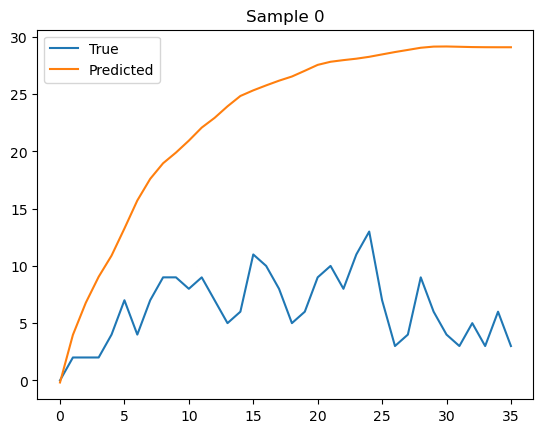

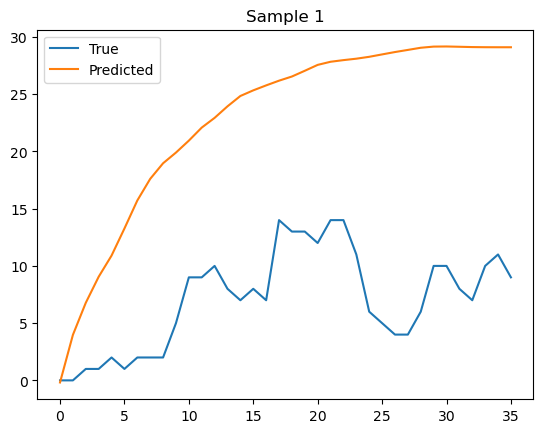

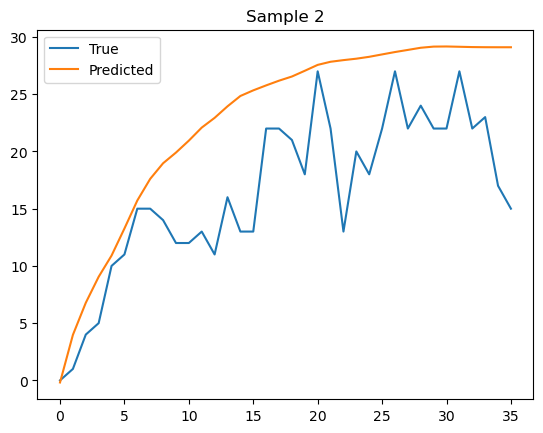

In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Assuming X_train and Y_train are numpy arrays
X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32)

# Split the data into training and validation sets
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_tensor, Y_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define the model
class GeneExpressionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GeneExpressionLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

# Model parameters
input_dim = 72
hidden_dim = 100
output_dim = 26
num_layers = 2

# Create model instance
model = GeneExpressionLSTM(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.unsqueeze(1).repeat(1, Y_batch.size(1), 1))
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
# Validating the model
model.eval()
val_loss = 0
with torch.no_grad():
    for X_val, Y_val in val_loader:
        output = model(X_val.unsqueeze(1).repeat(1, Y_val.size(1), 1))
        val_loss += criterion(output, Y_val).item()
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')

# Visualizing the fit on training data
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    X_train_tensor = X_tensor.unsqueeze(1).repeat(1, Y_tensor.size(1), 1)
    Y_pred_train = model(X_train_tensor)

for i in range(3):  # Plotting a few examples
    plt.figure()
    plt.plot(Y_train[i, :, 0], label='True')  # Plotting the true values for the first gene as an example
    plt.plot(Y_pred_train[i, :, 0], label='Predicted')  # Plotting the predicted values for the same gene
    plt.title(f'Sample {i}')
    plt.legend()
    plt.show()



## pyABC model

,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,260-270,270-280,280-290,290-300,300-310,310-320,320-330,330-340,340-350,350-360
lrp,1.891289,1.561839,0.793121,0.683304,1.452022,-0.085413,0.024404,0.463671,-0.744314,0.683304,...,-0.854130,-1.732665,-0.634497,-0.195230,0.902938,0.683304,1.012755,0.902938,1.122571,2.110922
aroF,-0.662511,0.228168,-1.058369,-0.860440,-0.266654,-0.068725,-0.068725,0.228168,-0.563547,1.316775,...,-1.058369,-0.464583,-0.959404,-0.464583,-0.662511,-0.167690,-0.761476,-0.266654,-0.266654,-0.068725
ihfA,-1.268927,-0.365159,0.292127,-0.775962,-1.022445,-0.940284,-0.611641,-0.529480,0.127806,0.456449,...,-0.365159,-0.036516,-1.186766,-0.036516,-1.186766,-1.186766,-0.775962,-1.186766,-1.761891,-1.268927
hupB,1.056453,0.033432,-0.688700,-0.869233,0.274143,-0.327634,-1.471010,-2.132965,-1.711721,-0.147101,...,-0.748878,0.575031,-1.170122,0.996275,2.320185,1.537875,1.537875,-1.170122,-0.327634,0.093610
hupA,0.738990,0.787536,-0.741687,-0.765960,-0.304766,-1.202881,-0.304766,-0.838780,-0.935874,0.326342,...,-0.013485,-0.256219,-0.280492,0.666169,1.224457,2.486673,2.219666,0.908903,1.175910,1.030270


(26, 36)

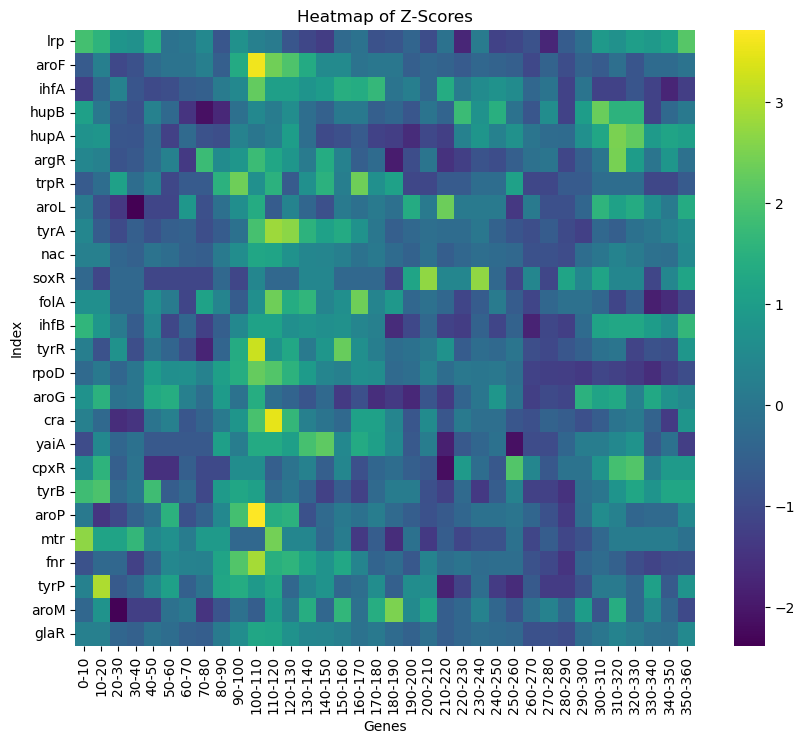

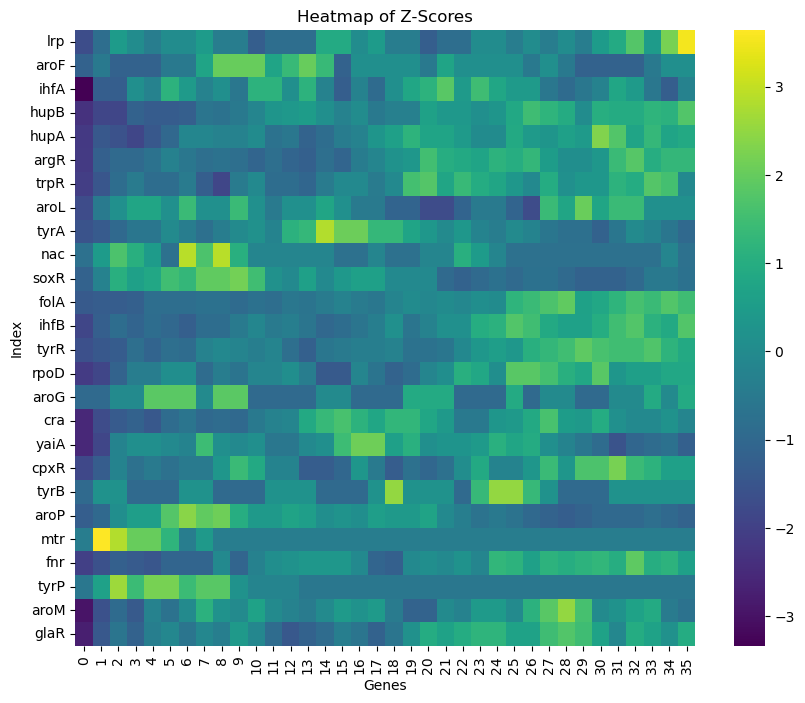

y_values shape: (26, 36)


In [ ]:
import pyabc
import pandas as pd
import numpy as np

import os
import tempfile
from scipy.stats import zscore
import multiprocessing


# Define a safe Z-score function to avoid NaN/Inf values
def safe_zscore(x):
    std = np.std(x)
    if std < 1e-10:  # Handle constant or near-constant data
        return np.zeros_like(x)
    return (x - np.mean(x)) / std


def generate_obs_data(grn_graph, param_sets, end_time, num_points, num_simulations, index_list=None):

    temp_antimony_str = create_antimony_model(grn_graph, param_sets[0])
    temp_rr_model = te.loada(temp_antimony_str)
    species_list = temp_rr_model.getFloatingSpeciesIds()
    
    for params in param_sets:
        sim_data = run_simulations_with_params(grn_graph, params, end_time, num_points, num_simulations)
        sim_df = save_results_to_dataframe(sim_data, species_list)
        #plot_results(sim_df)
    
        # Filter columns that start with 'mRNA_'
        mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]

        # Create a new DataFrame with only the filtered columns
        mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]

        # Rename the columns to remove the 'mRNA_' prefix
        mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
        
        # Aggregate results by Time, computing the sum for each gene
        aggregated_df = mRNA_df.groupby('Time').sum().reset_index()

        # Drop the 'Simulation' column
        aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])

        z_score_df = aggregated_df.apply(zscore).T

        reindexed_z_score_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df


        # Create the heatmap
        plt.figure(figsize=(10, 8))  # You can adjust the figsize as needed
        sns.heatmap(reindexed_z_score_df, cmap='viridis', cbar=True)

        # Add labels and title (optional)
        plt.xlabel('Genes')
        plt.ylabel('Index')
        plt.title('Heatmap of Z-Scores')

        # Show the plot
        plt.show()

        y_values = reindexed_z_score_df.values
        print(f"y_values shape: {y_values.shape}")

    return y_values


# def simulation_model(params, args):
#     #display(type(params))
#     #display(params)
#     #display(params.keys())

#     index_list = args['index_list']
#     # Run the simulation with the provided parameters
#     sim_data = run_simulations_with_params(args['grn_graph'], params, args['end_time'], args['num_points'], args['num_simulations'])
#     sim_df = save_results_to_dataframe(sim_data, args['species_list'])
    
#     mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]
#     mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]
#     mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
#     aggregated_df = mRNA_df.groupby('Time').sum().reset_index()
#     aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])
#     z_score_df = aggregated_df.apply(zscore).T
#     z_score_reindex_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df
#     y_values = z_score_reindex_df.values
#     return {'y': y_values}


# Modify  simulation model to handle potential errors
def simulation_model(params, args):
    try:
        # Run the simulation with the provided parameters
        sim_data = run_simulations_with_params(args['grn_graph'], params, args['end_time'], args['num_points'], args['num_simulations'])
        sim_df = save_results_to_dataframe(sim_data, args['species_list'])
        
        mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]
        mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]
        mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
        aggregated_df = mRNA_df.groupby('Time').sum().reset_index()
        aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])
        
        # Apply safe Z-score to avoid NaN/Inf
        z_score_df = aggregated_df.apply(safe_zscore).T
        z_score_reindex_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df
        y_values = z_score_reindex_df.values
        #y_values = z_score_df.values
        
        # Extra check to ensure no NaN/Inf values
        if np.any(np.isnan(y_values)) or np.any(np.isinf(y_values)):
            print(f"Warning: NaN/Inf values in simulation result with params {params}")
            return {'y': np.zeros_like(args['observed_shape'])}
            
        return {'y': y_values}
    except Exception as e:
        print(f"Error in simulation with params {params}: {str(e)}")
        return {'y': np.zeros_like(args['observed_shape'])}




# Define a robust distance function
def robust_distance(simulated_data, observed_data):
    sim_y = simulated_data['y']
    obs_y = observed_data['y']
    
    # Return a very large penalty for invalid results
    if np.any(np.isnan(sim_y)) or np.any(np.isinf(sim_y)):
        return 1e10
    
    # Use mean absolute error (more robust than squared error)
    return np.mean(np.abs(sim_y - obs_y))



# Create a wrapper function that captures the args in a closure
def create_model_wrapper(grn_graph, end_time, num_points, num_simulations, species_list, index_list, observed_shape):
    def model_function(parameters):
        args = {
            'grn_graph': grn_graph,
            'end_time': end_time,
            'num_points': num_points,
            'num_simulations': num_simulations,
            'species_list': species_list,
            'index_list': index_list,
            'observed_shape': observed_shape
        }
        return simulation_model(parameters, args)
    return model_function




# 'observational' data
tyrR_ecoli_TRIP_df = pd.read_csv("../TRIPS_data/tyrR_subnetwork_TRIP_zscore.csv", index_col=0)
index_list = list(tyrR_ecoli_TRIP_df.index)
#display(index_list)
display(tyrR_ecoli_TRIP_df.head())
display(tyrR_ecoli_TRIP_df.shape)
# Create the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the figsize as needed
sns.heatmap(tyrR_ecoli_TRIP_df, cmap='viridis', cbar=True)

# Add labels and title (optional)
plt.xlabel('Genes')
plt.ylabel('Index')
plt.title('Heatmap of Z-Scores')

# Show the plot
plt.show()



# simulated data
num_samples = 1
param_sets = generate_random_parameter_sets(parameters_with_bounds, num_samples)
_ = generate_obs_data(descendants_with_parents_subgraph, param_sets, end_time=30, num_points=36, num_simulations=5, index_list=index_list)
temp_antimony_str = create_antimony_model(descendants_with_parents_subgraph, param_sets[0])
temp_rr_model = te.loada(temp_antimony_str)
species_list = temp_rr_model.getFloatingSpeciesIds()





### ABC MODEL
obs_data = tyrR_ecoli_TRIP_df.values
observed_shape = obs_data.shape
observed_data = {'y': obs_data}




In [93]:
# Define priors using parameter_with_bounds
parameter_priors = {}
for param, bounds in parameters_with_bounds.items():
    nominal, lower, upper = bounds
    parameter_priors[param] = pyabc.RV("uniform", lower, upper - lower)

# Convert parameter_priors to pyabc.Distribution
parameter_priors_distribution = pyabc.Distribution(**parameter_priors)

# Define additional arguments
args = {
    'grn_graph': descendants_with_parents_subgraph,
    'end_time': 30,
    'num_points': 36,
    'num_simulations': 5,
    'species_list': species_list,
    'observed_shape': observed_shape
}

# Create the model function with your args
model_function = create_model_wrapper(
    grn_graph=descendants_with_parents_subgraph,
    end_time=30,
    num_points=36,
    num_simulations=5,
    species_list=species_list,
    index_list=index_list, 
    observed_shape=observed_shape
)



# Set up conservative sampler
sampler = pyabc.sampler.SingleCoreSampler()  # More stable than parallel

# Create ABC model with bounded transition
abc = pyabc.ABCSMC(
    models=model_function,
    parameter_priors=parameter_priors_distribution,
    distance_function=robust_distance,
    population_size=50,  # Smaller population for faster iterations
)

# Setup database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "abc_calibration.db")
abc.new(db_path, observed_data)

# Run with more conservative settings
history = abc.run(
    minimum_epsilon=0.5,  # Higher minimum epsilon
    max_nr_populations=5,  # Fewer populations
    min_acceptance_rate=0.001  # Lower acceptance rate threshold
)

# Create directory for diagnostics
os.makedirs("abc_diagnostics", exist_ok=True)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=13, start_time=2025-04-25 04:51:06>
ABC INFO: Calibration sample t = -1.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>"

KeyboardInterrupt: 

sbml_numpyro_env/lib/python3.11/site-packages/dateutil/__init__.py", line 16, in __getattr__
    from .. import tz
  File "<frozen importlib._bootstrap>", line 1229, in _handle_fromlist
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/site-packages/dateutil/__init__.py", line 16, in __getattr__
    from .. import tz
    from .. import tz
    from .. import tz
    from .. import tz      File "<frozen importlib._bootstrap>", line 1229, in _handle_fromlist
from .. import tz
  File "<frozen importlib._bootstrap>", line 1229, in _handle_fromlist
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/site-packages/dateutil/__init__.py", line 16, in __getattr__
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/site-packages/dateutil/__init__.py", line 16, in __getattr__

  File "<frozen importlib._bootstrap>", line 1229, in _handle_fromlist
  File "/Users/geor228/miniconda3/envs/sbml_numpyro_env/lib/python3.11/site-packages/dateutil/_

## EMCEE

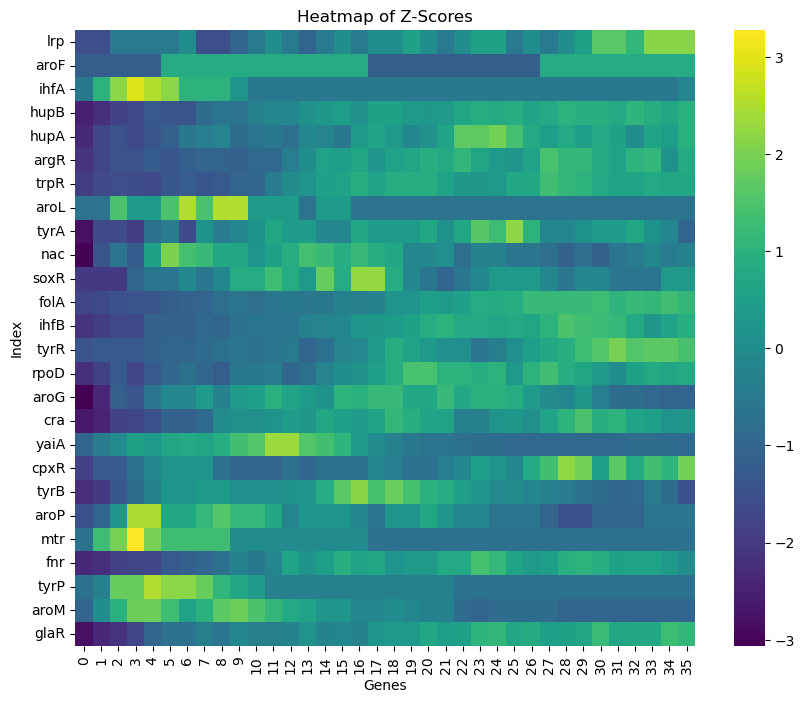

y_values shape: (26, 36)


100%|██████████| 10/10 [07:01<00:00, 42.12s/it]


In [109]:
import emcee
import numpy as np


# Modify  simulation model to handle potential errors
def simulation_model(params, args):
    try:
        # Run the simulation with the provided parameters
        param_dict = {name: value for name, value in zip(args['param_names'], params)}
        sim_data = run_simulations_with_params(args['grn_graph'], param_dict, args['end_time'], args['num_points'], args['num_simulations'])
        sim_df = save_results_to_dataframe(sim_data, args['species_list'])
        index_list = args['index_list']

        mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]
        mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]
        mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
        aggregated_df = mRNA_df.groupby('Time').sum().reset_index()
        aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])
        
        # Apply safe Z-score to avoid NaN/Inf
        z_score_df = aggregated_df.apply(safe_zscore).T
        z_score_reindex_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df
        y_values = z_score_reindex_df.values
        #y_values = z_score_df.values
        
        # Extra check to ensure no NaN/Inf values
        if np.any(np.isnan(y_values)) or np.any(np.isinf(y_values)):
            print(f"Warning: NaN/Inf values in simulation result with params {params}")
            return np.zeros_like(args['observed_shape'])
            
        return y_values
    except Exception as e:
        print(f"Error in simulation with params {params}: {str(e)}")
        return  np.zeros_like(args['observed_shape'])



def log_prior(params):
    for i, (lower, upper) in enumerate(bounds):
        if not (lower < params[i] < upper):
            return -np.inf  # Parameters out of bounds
    return 0.0  # Uniform prior within bounds


# Define the log-likelihood function
def log_likelihood(params, args):
    sim_result = simulation_model(params, args)
    y_model = sim_result
    y_obs = args['observed_data']

    # Assuming Gaussian likelihood for simplicity
    return -0.5 * np.sum(((y_obs - y_model) / args['y_err']) ** 2) 

# Define the log-probability function
def log_probability(params, args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, args)


#synthetic data
num_samples = 1
param_sets = generate_random_parameter_sets(parameters_with_bounds, num_samples)
_ = generate_obs_data(descendants_with_parents_subgraph, param_sets, end_time=30, num_points=36, num_simulations=5, index_list=index_list)
temp_antimony_str = create_antimony_model(descendants_with_parents_subgraph, param_sets[0])
temp_rr_model = te.loada(temp_antimony_str)
species_list = temp_rr_model.getFloatingSpeciesIds()


# observed data
tyrR_ecoli_TRIP_df = pd.read_csv("../TRIPS_data/tyrR_subnetwork_TRIP_zscore.csv", index_col=0)
index_list = list(tyrR_ecoli_TRIP_df.index)
observed_data = tyrR_ecoli_TRIP_df.values


# Extracting parameter bounds and nominal values
bounds = np.array([parameters_with_bounds[key][1:3] for key in parameters_with_bounds.keys()])
nominal_values = np.array([parameters_with_bounds[key][0] for key in parameters_with_bounds.keys()])

num_params = len(parameters_with_bounds)
num_steps = 10
num_walkers = int(num_params * 2)


# Initializing walkers: small Gaussian perturbation around nominal values
initial_guesses = nominal_values + 1e-4 * np.random.randn(num_walkers, num_params)

# Ensure initial guesses are within bounds
for i, (lower, upper) in enumerate(bounds):
    initial_guesses[:, i] = np.clip(initial_guesses[:, i], lower, upper)

# Running the MCMC sampler
args = {
    'grn_graph': descendants_with_parents_subgraph,
    'end_time': 30,
    'num_points': 36,
    'num_simulations': 3,
    'species_list': species_list,
    'observed_data': observed_data,  
    'observed_shape': observed_data.shape,
    'index_list': index_list,
    'y_err': 0.1, 
    'param_names': parameters_with_bounds.keys() 
}

sampler = emcee.EnsembleSampler(num_walkers, num_params, log_probability, args=(args,))
sampler.run_mcmc(initial_guesses, num_steps, progress=True)

# Get the samples
samples = sampler.get_chain()

Best parameters found: [3.59999791e+01 4.75001086e+01 5.89996963e+01 7.05999531e+01
 8.21000410e+01 9.35998608e+01 1.05100044e+02 1.16600066e+02
 1.28200015e+02 1.39700098e+02 1.51200067e+02 1.62700059e+02
 1.74199982e+02 1.85800101e+02 1.97300046e+02 2.08799950e+02
 2.20299833e+02 2.31799894e+02 2.43399747e+02 2.54899832e+02
 2.66399993e+02 2.77900032e+02 2.89400032e+02 3.01000076e+02
 3.12499802e+02 3.23999712e+02 2.99999307e+01 5.00170111e-01
 4.99847922e-01 5.00128255e-01 4.99928021e-01 5.00124207e-01
 5.00289185e-01 4.99994093e-01 5.00131450e-01 4.99969727e-01
 4.99898032e-01 4.99875130e-01 4.99953345e-01 5.00115726e-01
 5.00267139e-01 5.00084188e-01 5.00020682e-01 4.99899068e-01
 5.00027689e-01 5.00146342e-01 5.00021034e-01 4.99951958e-01
 4.99858543e-01 5.00063652e-01 5.00003383e-01 4.99956372e-01
 4.99840532e-01 2.00031024e-01 9.99748868e-02 4.99458838e-02
 1.99985133e+00 5.00012997e+00 5.00006455e+00 4.99987215e+00
 4.99996711e+00 4.99998235e+00 5.00004331e+00 4.99985273e+00
 

<Axes: >

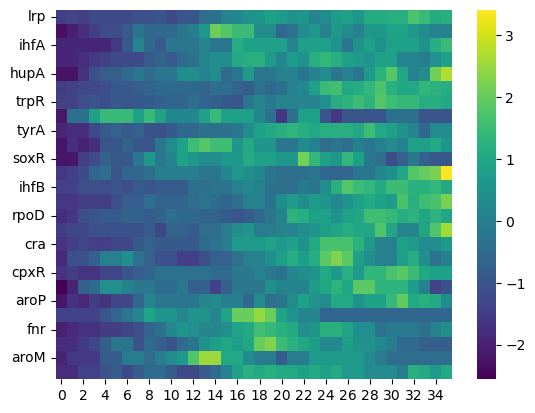

In [112]:
# Getting the log-probabilities (log-posterior)
log_prob_samples = sampler.get_log_prob(flat=True)

# Getting the samples
samples = sampler.get_chain(flat=True)

# Best parameters as those with the highest log-probability
best_index = np.argmax(log_prob_samples)
best_params = samples[best_index]
print(f"Best parameters found: {best_params}")


# Modify  simulation model to handle potential errors
def simulation_model_df(params, args):
    param_dict = {name: value for name, value in zip(args['param_names'], params)}
    sim_data = run_simulations_with_params(args['grn_graph'], param_dict, args['end_time'], args['num_points'], args['num_simulations'])
    sim_df = save_results_to_dataframe(sim_data, args['species_list'])
    index_list = args['index_list']

    mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]
    mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]
    mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
    aggregated_df = mRNA_df.groupby('Time').sum().reset_index()
    aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])
    
    # Apply safe Z-score to avoid NaN/Inf
    z_score_df = aggregated_df.apply(safe_zscore).T
    z_score_reindex_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df
    return z_score_reindex_df

best_params_df = simulation_model_df(best_params, args)
sns.heatmap(best_params_df, cmap='viridis', cbar=True)

<Axes: >

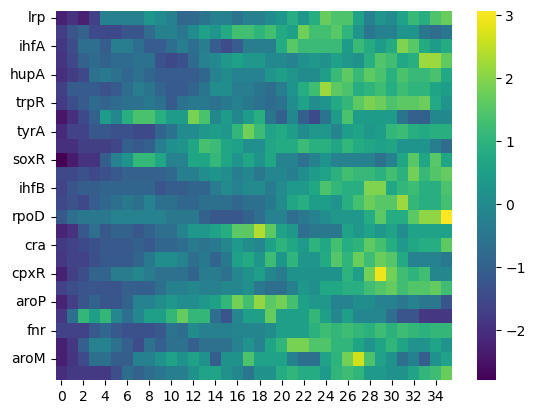

In [151]:
# intervene 
intervened_descendants_with_parents_subgraph = descendants_with_parents_subgraph.copy()

target_gene = 'tyrR'
factor = 10

# Remove all incoming edges to the target gene
incoming_edges = list(intervened_descendants_with_parents_subgraph.in_edges(target_gene))
intervened_descendants_with_parents_subgraph.remove_edges_from(incoming_edges)

args['grn_graph'] = intervened_descendants_with_parents_subgraph
args[f'k_{target_gene}'] = 10

# Modify  simulation model to handle potential errors
def simulation_model_df(params, args):
    param_dict = {name: value for name, value in zip(args['param_names'], params)}
    sim_data = run_simulations_with_params(args['grn_graph'], param_dict, args['end_time'], args['num_points'], args['num_simulations'])
    sim_df = save_results_to_dataframe(sim_data, args['species_list'])
    index_list = args['index_list']

    mRNA_columns = [col for col in sim_df.columns if col.startswith('mRNA_')]
    mRNA_df = sim_df[['Time', 'Simulation'] + mRNA_columns]
    mRNA_df.columns = ['Time', 'Simulation'] + [col.replace('mRNA_', '') for col in mRNA_columns]
    aggregated_df = mRNA_df.groupby('Time').sum().reset_index()
    aggregated_df = aggregated_df.drop(columns=['Simulation', 'Time'])
    
    # Apply safe Z-score to avoid NaN/Inf
    z_score_df = aggregated_df.apply(safe_zscore).T
    z_score_reindex_df = z_score_df.reindex(index_list) if index_list is not None else z_score_df
    return z_score_reindex_df

intervention_df = simulation_model_df(best_params, args)
sns.heatmap(intervention_df, cmap='viridis', cbar=True)


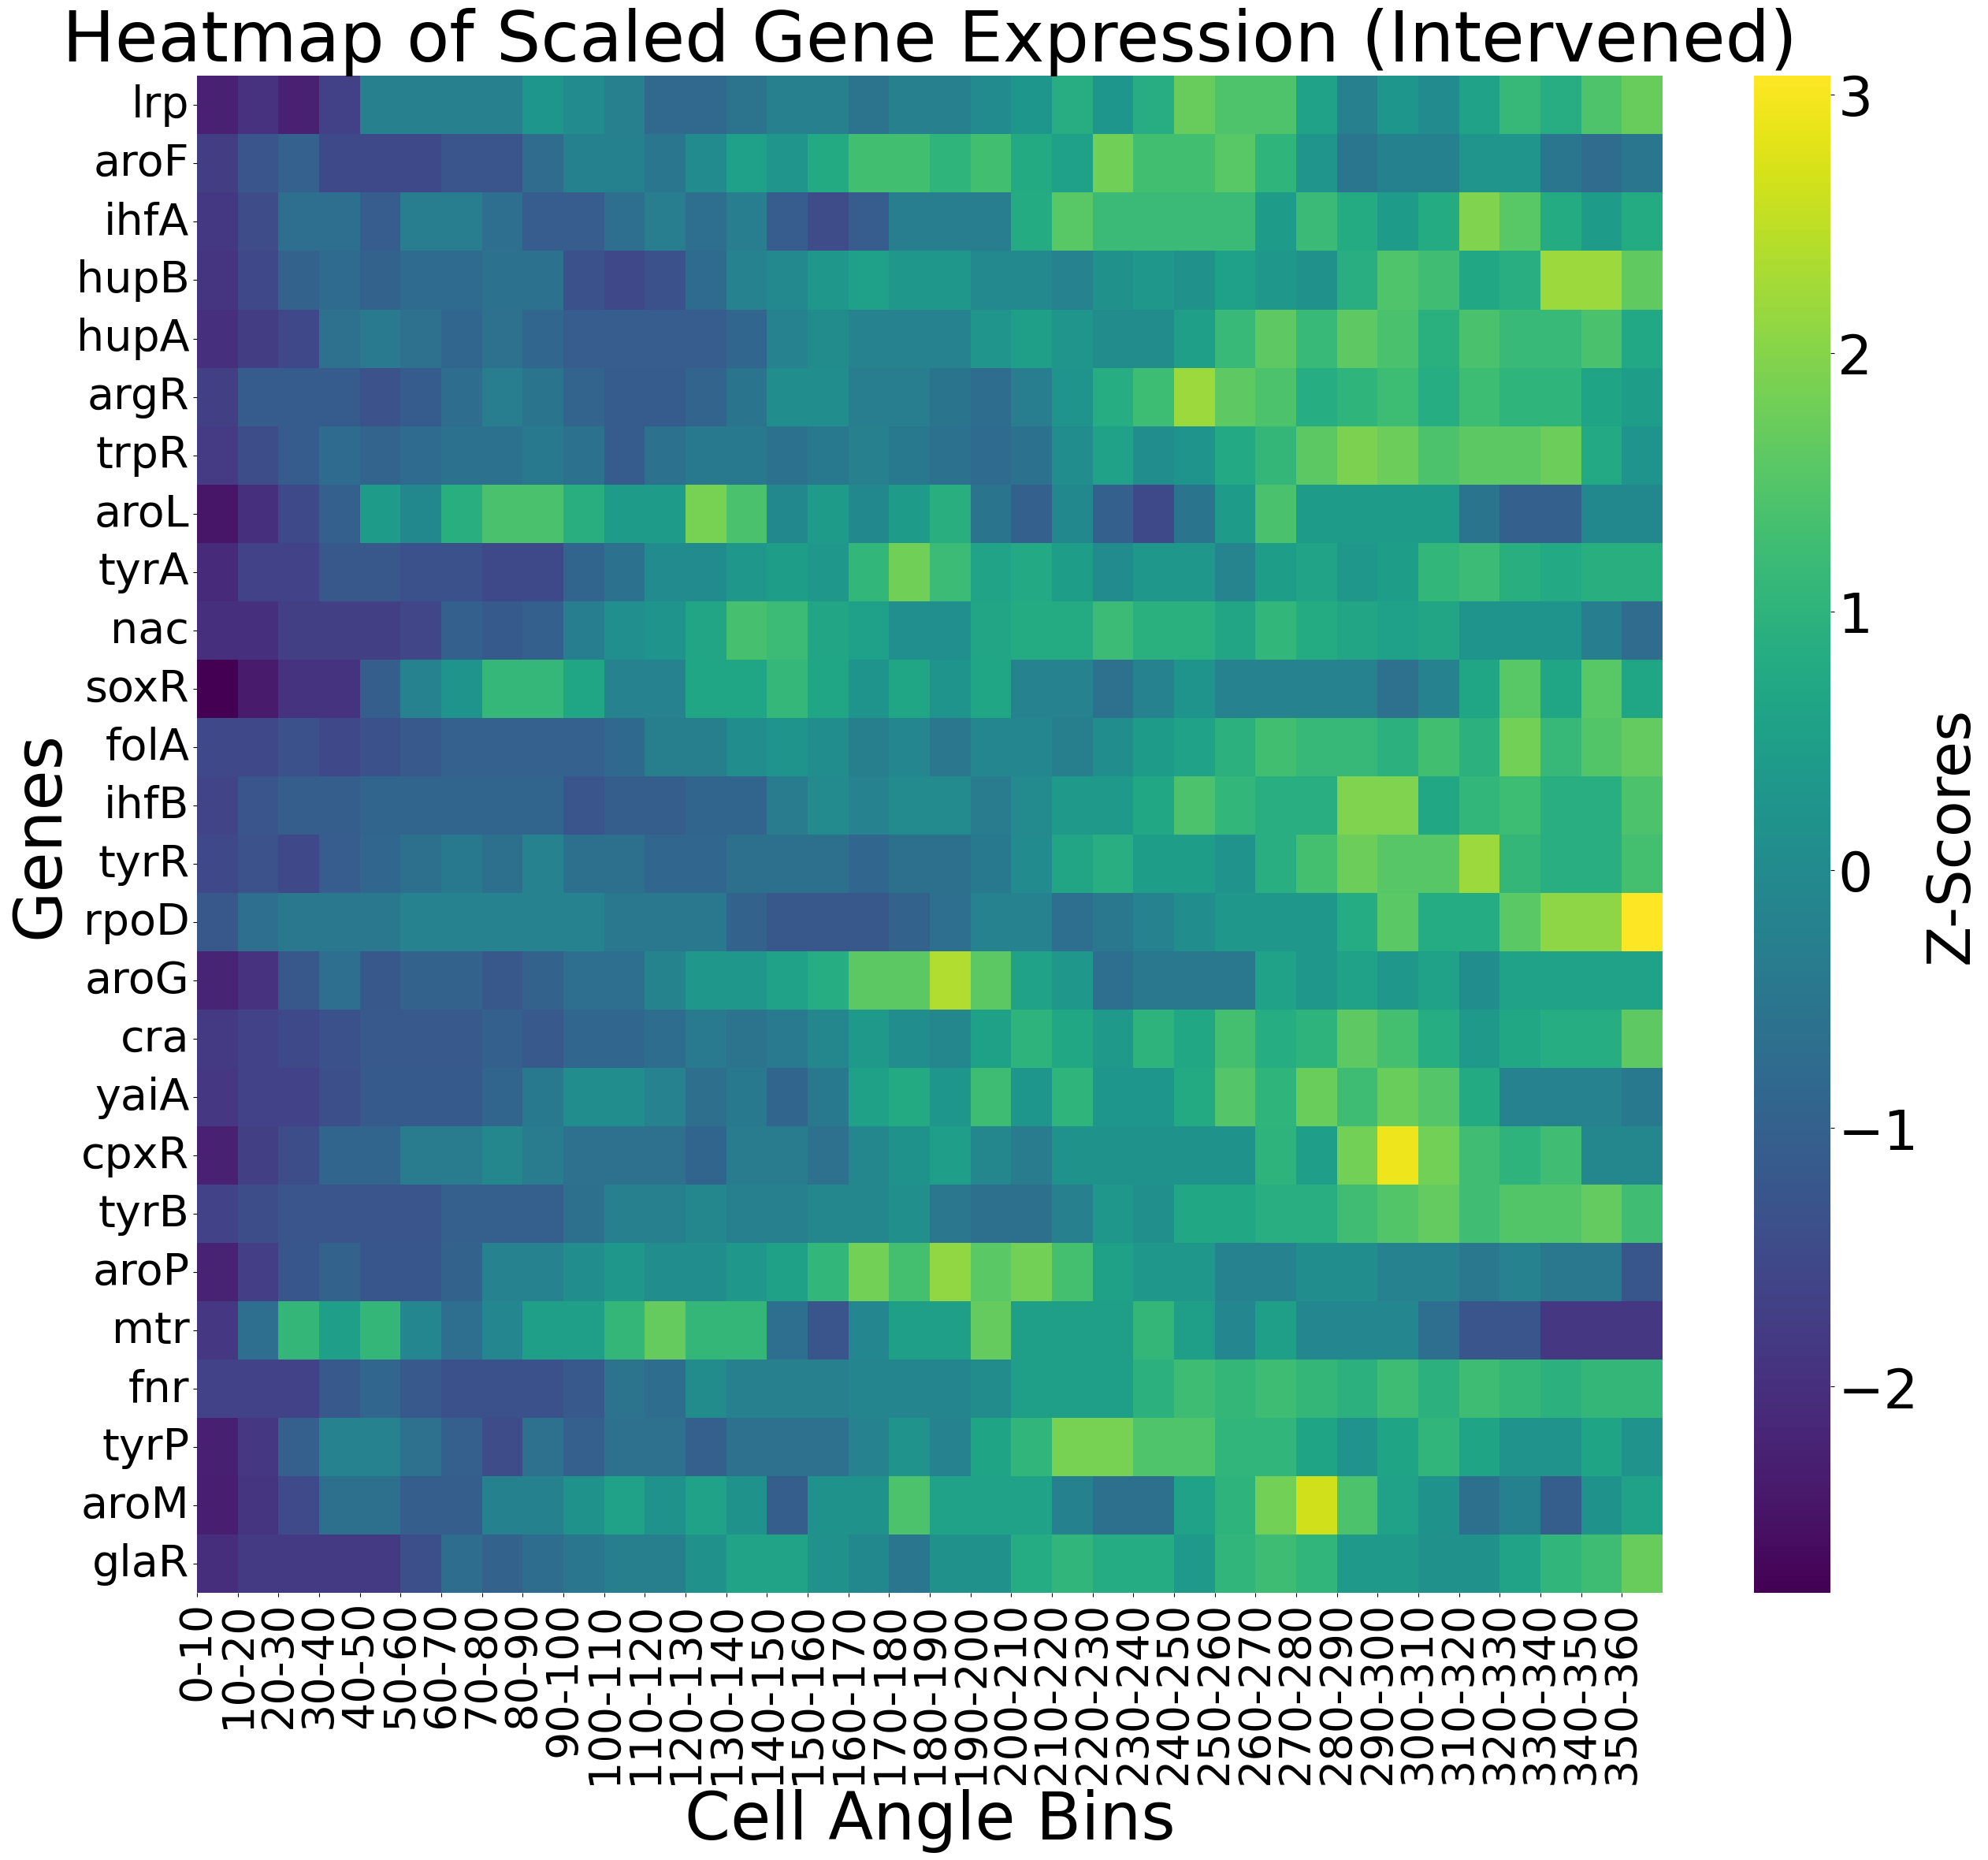

In [160]:
# Set up the matplotlib figure
plt.figure(figsize=(30, 25))

# Create the heatmap using seaborn
sns.heatmap(intervention_df, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Z-Scores'}, xticklabels=True, yticklabels=True)

# Set the labels and title with increased font size
plt.xlabel('Cell Angle Bins', fontsize=60)
plt.ylabel('Genes', fontsize=60)
plt.title('Heatmap of Scaled Gene Expression (Intervened)', fontsize=64)

# Customize x-axis tick labels font size and set custom labels
x_tick_labels = [f"{i*10}-{(i+1)*10}" for i in range(intervention_df.shape[1])]
plt.xticks(ticks=range(len(x_tick_labels)), labels=x_tick_labels, fontsize=40, rotation=90)  # You can adjust the rotation angle as needed

# Customize y-axis tick labels font size and rotation
plt.yticks(fontsize=40, rotation=0)  # You can adjust the rotation angle as needed

# Customize the color bar font size
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=50)
cbar.set_ylabel('Z-Scores', fontsize=54)

# Save the figure with a transparent background and high DPI resolution, using bbox_inches to reduce white space
plt.savefig("heatmap_poster_intervention.png", dpi=300, transparent=True, bbox_inches='tight')

# Show the plot
plt.show()

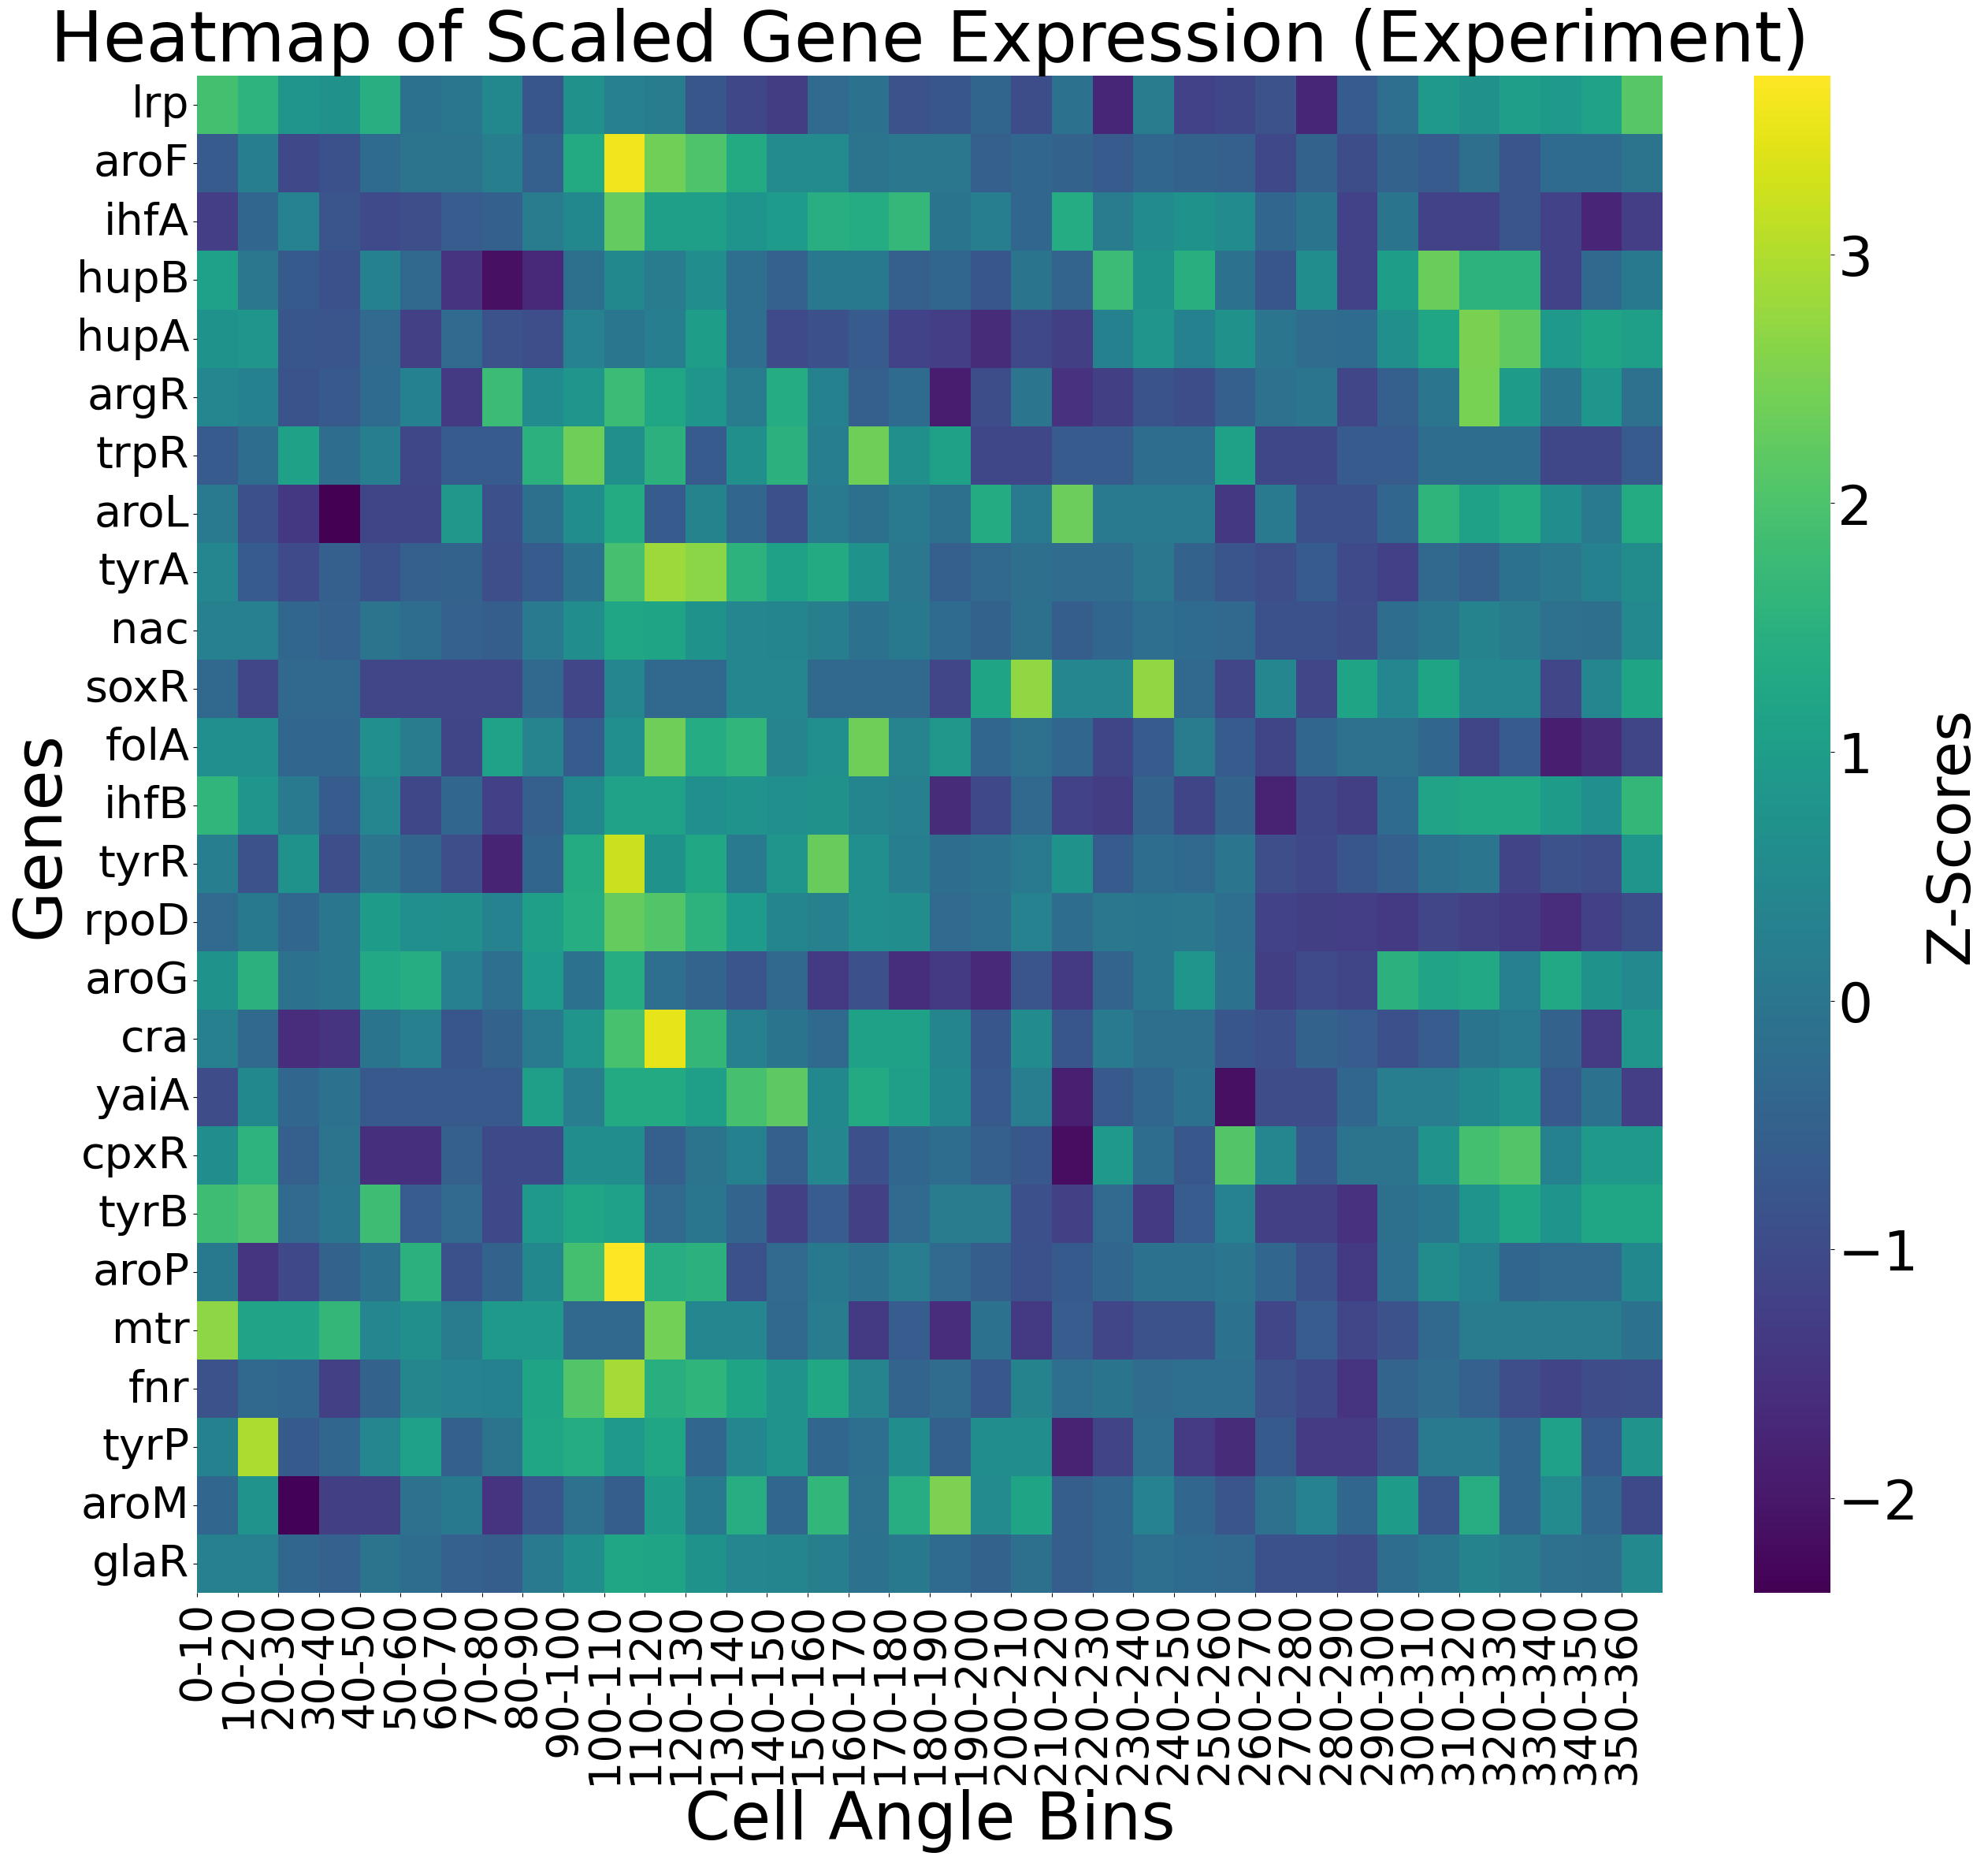

In [161]:
# Set up the matplotlib figure
plt.figure(figsize=(30, 25))

# Create the heatmap using seaborn
sns.heatmap(tyrR_ecoli_TRIP_df, cmap='viridis', annot=False, fmt=".2f", cbar_kws={'label': 'Z-Scores'}, xticklabels=True, yticklabels=True)

# Set the labels and title with increased font size
plt.xlabel('Cell Angle Bins', fontsize=60)
plt.ylabel('Genes', fontsize=60)
plt.title('Heatmap of Scaled Gene Expression (Experiment)', fontsize=64)

# Customize x-axis tick labels font size and set custom labels
x_tick_labels = [f"{i*10}-{(i+1)*10}" for i in range(intervention_df.shape[1])]
plt.xticks(ticks=range(len(x_tick_labels)), labels=x_tick_labels, fontsize=40, rotation=90)  # You can adjust the rotation angle as needed

# Customize y-axis tick labels font size and rotation
plt.yticks(fontsize=40, rotation=0)  # You can adjust the rotation angle as needed

# Customize the color bar font size
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=50)
cbar.set_ylabel('Z-Scores', fontsize=54)

# Save the figure with a transparent background and high DPI resolution, using bbox_inches to reduce white space
plt.savefig("heatmap_poster_experimental.png", dpi=300, transparent=True, bbox_inches='tight')

# Show the plot
plt.show()